# Investigation of Traffic Volume in Scotland, 2000-2019

# Preparations
- 1. Install packages
- 2. Import modules

In [ ]:
# To install packages which do not come pre-installed with Anaconda
# To install plotly
# method 1:
conda install -c plotly plotly 
# method 2:
# For mac:
pip install "notebook>=5.3" "ipywidgets==7.5"
pip install plotly==4.12.0
# method 3:
# For windows:
pip install plotly

# To install folium
conda install -c conda-forge folium

In [1]:
# Import modules
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import folium.plugins
import requests
import urllib, json
import warnings
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller as ADF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Ignore warnings
warnings.filterwarnings("ignore")

# [references] all the coding about plotly are all from URL: https://plotly.com/python/line-charts/

1. [How to install folium](https://github.com/python-visualization/folium)
2. [How to install plotly](https://anaconda.org/plotly/plotly)
2. [Chrome issue reference](https://github.com/python-visualization/folium/issues/812)
3. [Reference for sunburst chart](https://plotly.com/python/sunburst-charts/)

# Abstract:
- This report is mainly about an investigation of ```traffic volume```.


- Considering that the data of count points and roads is the primary dataset that we use to calculate the traffic volume, we firstly process data and visualize the information related to the count points, roads and vehicle distribution before going into deep dives on the analysis of traffic volume, to achieve a preliminary understanding of the data. In Part 1, 2 and 3, we analyzed: 1) the distribution of CPs in roads and Scotland as a whole; 2) the length and density of roads in each local authority; 3) and the use of different vehicles in different locations.


- In Part 4, 5, and 6, we firstly analyzed the annual traffic volume in the past 20 years by vehicle type and road type, then forecast the total traffic volume for the next 6 years. In addition, we did detailed analysis on the traffic volume by each vehicle type. And due to limited road type data, we introduced another database([gov.uk, 2020](https://www.gov.uk/government/statistical-data-sets/road-length-statistics-rdl)) to calculate and analyze the B\C\U road using unofficial methods.

## 1. The Analysis of Count Points in 2019 and Length of Major Roads
🚩```Analysis Questions```
- What is the location distribution of count points in 2019?
- What is the location distribution of major roads?
- The general statistical description of the number of count points in each road (excluding U and C roads) in 2019(which road has the largest number of count points?)
- The general statistical description of road lengths (how many major roads in Scotland? what is the distribution of the data? which road is the longest?).

📚```Methodology```
- To get a general idea of the location distribution of count points and major roads, we firstly organize the information (count point id, location, local authority, road name) of each count point in 2019 and extract data of locations of each major road. We also calculate the length of each major road and the number of count points in each road (excluding U and C roads) based on availble data. 
- Then we put markers in a map to display the locations and other useful information of each count point and major road. In addition, we make two histograms to display the distribution of road lengths and count points in each road.
- How we calculate the length of each major road: following the official document's instruction, we sum up the lengths of all the links of in each major road to get the total length of each road.
- References: [Road Lengths in Great British Statistics: Methodology Note](https://www.gov.uk/government/statistics/road-lengths-in-great-britain-2019)


### 1.1 Location Distributions of Count Points in 2019 and Major Roads

In [2]:
# Process the data of the location of each count point
# Set some variables
profile = 'dft_rawcount_region_id_3.csv'
variable_list = ['count_point_id','year',"road_name",'local_authority_name','latitude','longitude']
the_year = 2019

# Creat a new dataframe to store necessary information
total_frame = pd.read_csv(profile,dtype={'start_junction_road_name':'str','end_junction_road_name': 'str'})
cps_frame = total_frame.loc[total_frame["year"] == the_year, variable_list]

# Drop duplicate rows, sort the values, and reset index
cps_frame = cps_frame.drop_duplicates()
cps_frame = cps_frame.sort_values(by=['count_point_id'], ascending=True)
cps_frame.reset_index(drop=True, inplace=True)

# Display the results
cps_frame.info

count_point_id  year road_name local_authority_name   latitude  longitude
0             761  2019       A82             Stirling  56.342497  -4.717747
1             793  2019      A830             Highland  56.838257  -5.081561
2            1011  2019        A8         Glasgow City  55.855427  -4.245153
3            1029  2019       A80         Glasgow City  55.867611  -4.192472
4            1055  2019       A95                Moray  57.446623  -3.267937

In [3]:
# Get necessary data of major roads
rows = total_frame['road_name'].str.startswith('A') | total_frame['road_name'].str.startswith('M')
road_length = total_frame.loc[rows, ['count_point_id', 'local_authority_name', 'road_name', 'link_length_miles']]

# Drop duplicate rows
# Some count_point_id have different link lengths, we only use the lastest lengths
road_length = road_length.drop_duplicates(subset=['count_point_id', 'local_authority_name', 'road_name'], keep='first')

# Group the dataframe by road_name and calculate the sum of link length
road_length_each = pd.DataFrame(road_length.groupby(['road_name']).link_length_miles.sum())
# Sort the dataframe by the value of link length
road_length_each = road_length_each.sort_values(by=['link_length_miles'], ascending=False)
road_length_each = road_length_each.loc[road_length_each['link_length_miles'] != 0, :]

In [4]:
road_length_each.reset_index(inplace=True)

In [5]:
# Reference:
# Line 18,21,24,25,30: Jessica Walkenhorst
# URL: https://walkenho.github.io/beergarden-happiness-with-python/
# Accessed on 30 Nov 2020.

# It will take about 2-5 minutes to run the code in this cell, so please just wait😝...wait😋...wait🐶...
def get_address(name):
    '''
    This function is to search information of specific places from open streetmap.
    
    Input:
    name(str): name of the place that we want to search.
    
    Output:
    result(json), search result from open street map.
    '''
    # The url of open streetmap website
    url = 'https://nominatim.openstreetmap.org/search'
    # The content that we want to input in the search box, here we specify that searching places in Scotland only
    # We also specify the format
    parameters = {'q':'{}, Scotland'.format(name), 'format':'json'}
    
    # Get the responses and JSON objects of the results
    response = requests.get(url, params=parameters)
    result = response.json()
    
    return result

# Apply the function to the elements in the seriese, road_length_each['road_name'], to get information of each road
road_length_each['json'] = road_length_each['road_name'].map(lambda x: get_address(x))

In [6]:
# Check the results
road_length_each.head()

road_name  link_length_miles  \
0        A9             276.64   
1       A90             172.18   
2       A82             170.26   
3      A836             120.73   
4      A832             114.47   

                                                json  
0  [{'place_id': 147467369, 'licence': 'Data © Op...  
1  [{'place_id': 94388665, 'licence': 'Data © Ope...  
2  [{'place_id': 84219568, 'licence': 'Data © Ope...  
3  [{'place_id': 129553739, 'licence': 'Data © Op...  
4  [{'place_id': 100163686, 'licence': 'Data © Op...

In [7]:
# Check a specific object
road_length_each.iloc[0,2]

[{'place_id': 147467369,
  'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
  'osm_type': 'way',
  'osm_id': 232815866,
  'boundingbox': ['58.5211314', '58.5916955', '-3.5223293', '-3.4510105'],
  'lat': '58.5567167',
  'lon': '-3.4914796',
  'display_name': 'A9, Mount Vernon, Thurso, Caithness, Scotland, KW14 8QS, United Kingdom',
  'class': 'highway',
  'type': 'trunk',
  'importance': 0.32},
 {'place_id': 123746491,
  'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
  'osm_type': 'way',
  'osm_id': 145180103,
  'boundingbox': ['58.5137819', '58.5211314', '-3.4524534', '-3.4509389'],
  'lat': '58.5184077',
  'lon': '-3.4522554',
  'display_name': 'A9, Sibster, Caithness, Scotland, KW12 6UU, United Kingdom',
  'class': 'highway',
  'type': 'trunk',
  'importance': 0.32},
 {'place_id': 100887262,
  'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
  'osm_type': 'way',
  'osm_id': 

In [8]:
# Reference:
# Line 8, 10-11: Jessica Walkenhorst
# URL: https://walkenho.github.io/beergarden-happiness-with-python/
# Accessed on 30 Nov 2020.

# It seems that we possibly got several responses (or empty response) for one research, so we decide to choose the first result only
# Get rid of empty responses
road_length_each2 = road_length_each[road_length_each['json'].map(lambda a: len(a)) > 0].copy()
# Get the coordinates information of each road and append new serieses to the original dataframe
road_length_each2['latitude'] = road_length_each2['json'].map(lambda x: x[0]['lat'])
road_length_each2['longitude'] = road_length_each2['json'].map(lambda x: x[0]['lon'])
# Round the number of road length
road_length_each2['link_length_miles'] = road_length_each2['link_length_miles'].round()

# Display the result
road_length_each2.head(10)

road_name  link_length_miles  \
0        A9              277.0   
1       A90              172.0   
2       A82              170.0   
3      A836              121.0   
4      A832              114.0   
5       A93              109.0   
6       A87              100.0   
7       A96               99.0   
8       A83               99.0   
9       A75               97.0   

                                                json    latitude   longitude  
0  [{'place_id': 147467369, 'licence': 'Data © Op...  58.5567167  -3.4914796  
1  [{'place_id': 94388665, 'licence': 'Data © Ope...  57.1226298   -2.117886  
2  [{'place_id': 84219568, 'licence': 'Data © Ope...   55.874625  -4.2793653  
3  [{'place_id': 129553739, 'licence': 'Data © Op...  58.6159469  -3.3452834  
4  [{'place_id': 100163686, 'licence': 'Data © Op...  57.6804862   -4.036583  
5  [{'place_id': 229102019, 'licence': 'Data © Op...  57.1015478  -2.2450674  
6  [{'place_id': 98784352, 'licence': 'Data © Ope...  57.2751143  -5.7438585  
7  [{'place_id': 185759271, 'licence': 'Data © Op...  57.1909349  -2.2141563  
8  [{'place_id': 95503455, 'licence': 'Data © Ope...  56.2356583  -5.0705041  
9  [{'place_id': 172451776, 'licence': 'Data © Op...   55.026703  -3.3860284

In [9]:
# Reference:
# Line 9-10, 13, 21, 33-34, 61, 62, 65, 67: folium documentation (quickstart and one simple example from the gallery)
# URL1: https://python-visualization.github.io/folium/quickstart.html
# URL2: https://nbviewer.jupyter.org/github/python-visualization/folium_contrib/blob/master/notebooks/ClusteredMarker_and_FeatureGroup.ipynb
# Accessed on 28 Nov 2020.

# Create an empty map
# Take the coordinate of the center of Edinburgh as the starting point
map_general = folium.Map(location=[55.9533456,-3.1883749], zoom_start=12)
folium.raster_layers.TileLayer()

# Create several featuregroups to generate different layers of map
group_M = folium.FeatureGroup(name='M')
group_A = folium.FeatureGroup(name='A')
group_B = folium.FeatureGroup(name='B')
group_C = folium.FeatureGroup(name='C')
group_U = folium.FeatureGroup(name='U')
group_road_length = folium.FeatureGroup(name='Road length')

# Create several markerclusters to seperate markers of count points in different types of roads
MC_M = folium.plugins.MarkerCluster()
MC_A = folium.plugins.MarkerCluster()
MC_B = folium.plugins.MarkerCluster()
MC_C = folium.plugins.MarkerCluster()
MC_U = folium.plugins.MarkerCluster()
MC_RL = folium.plugins.MarkerCluster()

# Create markers for count points and display related information
# Differentiate count points with different colors of icons
for i in range(len(cps_frame['count_point_id'])):
    popup = '<b>'+str(cps_frame.iloc[i, 0])+',\n'+str(cps_frame.iloc[i, 2])+',\n'+str(cps_frame.iloc[i, 3])+'</b>'
    if cps_frame.iloc[i, 2][0] == 'M':
        marker_M = folium.Marker([cps_frame.iloc[i, 4], cps_frame.iloc[i, 5]], popup=popup, 
                  icon=folium.Icon(color='blue', icon='flag'), tooltip='Count point').add_to(MC_M)
    elif cps_frame.iloc[i, 2][0] == 'A':
        marker_A = folium.Marker([cps_frame.iloc[i, 4], cps_frame.iloc[i, 5]], popup=popup, 
                  icon=folium.Icon(color='lightblue', icon='flag'), tooltip='Count point').add_to(MC_A)
    elif cps_frame.iloc[i, 2][0] == 'B':
        marker_B = folium.Marker([cps_frame.iloc[i, 4], cps_frame.iloc[i, 5]], popup=popup, 
                  icon=folium.Icon(color='cadetblue', icon='flag'), tooltip='Count point').add_to(MC_B)
    elif cps_frame.iloc[i, 2] == 'C':
        marker_C = folium.Marker([cps_frame.iloc[i, 4], cps_frame.iloc[i, 5]], popup=popup, 
                  icon=folium.Icon(color='lightred', icon='flag'), tooltip='Count point').add_to(MC_C)
    elif cps_frame.iloc[i, 2] == 'U':
        marker_U = folium.Marker([cps_frame.iloc[i, 4], cps_frame.iloc[i, 5]], popup=popup, 
                  icon=folium.Icon(color='lightgreen', icon='flag'), tooltip='Count point').add_to(MC_U)
    else:
        pass
    
# Create markers for roads and display its estimated total length
for j in range(len(road_length_each2)):
    popup2 = '<b>'+str(road_length_each2.iloc[j, 0])+',\n'+str(road_length_each2.iloc[j, 1])+' miles'+'</b>'
    marker_rl = folium.Marker([road_length_each2.iloc[j, 3], road_length_each2.iloc[j, 4]], popup=popup2, 
                icon=folium.Icon(color='beige', icon='map-marker'), tooltip='Road').add_to(MC_RL)

# Loop over each group and markercluster
# Add each makercluster to its correspondent group, then add each group to the base map
groups = [group_M, group_A, group_B, group_C, group_U, group_road_length]
MCs = [MC_M, MC_A, MC_B, MC_C, MC_U, MC_RL]
for i in range(6):
    groups[i].add_child(MCs[i])
    map_general.add_child(groups[i])

# Create layers
map_general.add_child(folium.LayerControl())
# Save the map as html file
map_general.save('General Map.html')
# Display the map (the button at the up right corner can be used to switch layers)
# You can click the markers in this map to get more information about the count points / roads
map_general

### 1.2 The general statistical description of the number of count points in each road (excluding U and C roads) in 2019

In [10]:
# Count the number of count points of each road
# Creat a group by road name
road_nsofcp = cps_frame.groupby('road_name')
# Calculate the number of count points of each road
newdf = road_nsofcp.size()
newdf = newdf.reset_index(name='cps_of_the_road')
newdf = newdf.sort_values(by=['cps_of_the_road'], ascending=False)
newdf.reset_index(drop=True, inplace=True)
newdf = newdf.set_index(newdf['road_name'])
newdf = newdf.drop(columns='road_name')
# Show the results
newdf.head()

cps_of_the_road
road_name                 
U                      309
C                      161
A9                      12
A90                      6
A92                      4

In [11]:
newdf.describe()

cps_of_the_road
count       252.000000
mean          3.222222
std          21.818479
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         309.000000

Text(0.5, 1.0, 'Count Point Number in Each Road Histogram')

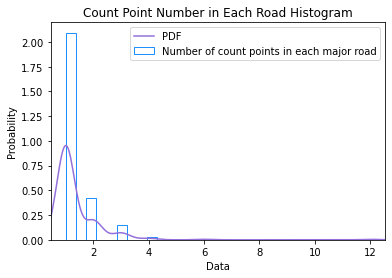

In [12]:
# Reference: 
# Line 14-16: Scipy documentation
# URL: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html
# Accessed on 30 Nov 2020.

# Make a histogram of road length
x = newdf['cps_of_the_road'][2:]
plt.hist(x, density=True, bins=30, histtype='step', color='dodgerblue', label='Number of count points in each major road')
# Set the limits of x-axis
min, max = plt.xlim()
plt.xlim(min, max)
# Get data of x to produce the plot of probability density function
kde_x = np.linspace(min, max, 301)
# Calculate the data of y using probability density function
kde = st.gaussian_kde(x)
# Make the plot of PDF
plt.plot(kde_x, kde.pdf(kde_x), label='PDF', color='mediumpurple' )
plt.legend(loc='upper right')
plt.ylabel('Probability')
plt.xlabel('Data')
plt.title('Count Point Number in Each Road Histogram')

### 1.3 The general statistical description of road lengths

In [13]:
# Get basic statistical descriptions of road length
road_length_each['link_length_miles'].describe()

count    287.000000
mean      23.597387
std       30.903298
min        0.250000
25%        4.540000
50%       13.730000
75%       30.660000
max      276.640000
Name: link_length_miles, dtype: float64

Text(0.5, 1.0, 'Major Road Length Histogram')

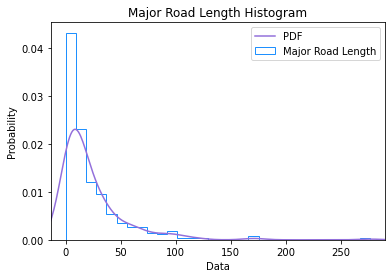

In [14]:
# Make a histogram of road length
x = road_length_each['link_length_miles']
plt.hist(x, density=True, bins=30, histtype='step', color='dodgerblue', label='Major Road Length')
# Set the limits of x-axis
min, max = plt.xlim()
plt.xlim(min, max)
# Get data of x to produce the plot of probability density function
kde_x = np.linspace(min, max, 301)
# Calculate the data of y using probability density function
kde = st.gaussian_kde(x)
# Make the plot of PDF
plt.plot(kde_x, kde.pdf(kde_x), label='PDF', color='mediumpurple' )
plt.legend(loc='upper right')
plt.ylabel('Probability')
plt.xlabel('Data')
plt.title("Major Road Length Histogram")

## Conclusions
### 1.1.1 The distribution of count points in 2019:
- From the General Map, we can see that most count points are located at the central and southern part of Scotland. They are concentrated in and around big cities such as Glasgow, Edinburgh, Dundee, and Aberdeen. Some count points are distributed in or around smaller cities and towns such as Alexandria, Lennoxtown, Forfar, etc. while some locate at rural areas and beside natural lanscape such as forests. 
- Generally speaking, U roads have the largest number of count points, C roads have the second largest number, then B roads, A roads, and M roads. Count points in M roads are located in and near the city of Glasgow. The distributions of count points in A, B, C, and U roads are generally similar.

### 1.1.2 The distribution of major roads:
- The General Map shows that most major roads are located around big cities while some of them are along coastlines and cross landscapes such as highlands and forests.

### 1.2 The statistical description of the number of count points in each road (excluding C and U roads):
- Excluding U-road and C-road, more than 75% of the roads have only one counting point per road. There are 19 roads with no less than 3 count points. The one with the most count points is A9, a total of 12 points.

### 1.3 The statistical descriptions of major road lengths: 
- The analysis above shows that the total number of major roads is 287 and the longest road is A9 (276.64 miles). However, there are only seven major roads whose lengths are over 100 miles. The average value of major road lengths is 23.60 miles and the road length of 75% roads is less than 50 miles.

## 2. The Analysis of the Use of Different Types of Vehicles in 2019
🚩```Analysis Questions```
- What is the distribution of each vehicle type? (where people most use bikes, where most light goods vans drive?...)

📚```Methodology```
- We sum up the number of each type of vehicle counted in each count point in 2019 and display the results with heatmaps. Each layer in the map displays the distribution of each vehicle type.

In [15]:
# Process the data of the number of each vehicles at each count point
variable_list2 = ['count_point_id','year','pedal_cycles','two_wheeled_motor_vehicles', 'cars_and_taxis', 'buses_and_coaches', 'lgvs', 'all_hgvs', 'all_motor_vehicles']
cps_frame2 = total_frame.loc[total_frame["year"] == the_year, variable_list2]
cps_frame2 = cps_frame2.sort_values(by=['count_point_id'], ascending=True)
cps_frame2.reset_index(drop=True, inplace=True)

# Display the results
cps_frame2.head()

count_point_id  year  pedal_cycles  two_wheeled_motor_vehicles  \
0             761  2019             0                          18   
1             761  2019             0                           5   
2             761  2019             1                           6   
3             761  2019             0                           0   
4             761  2019             0                           4   

   cars_and_taxis  buses_and_coaches  lgvs  all_hgvs  all_motor_vehicles  
0             118                  3    26        11                 176  
1              66                  2    17        11                 101  
2             109                  6    24         5                 150  
3              18                  0     8         5                  31  
4              58                  3    44        10                 119

In [16]:
# Group by the number of vehicles by each count point
vehicle_num = cps_frame2.groupby('count_point_id')[variable_list2[2:]].sum()
vehicle_num.reset_index(inplace=True)

# Display the results
vehicle_num.head()

count_point_id  pedal_cycles  two_wheeled_motor_vehicles  cars_and_taxis  \
0             761            28                         114            2423   
1             793            95                         123            6411   
2            1011           239                          61            9406   
3            1029            52                          17            6073   
4            1055             0                          73            2356   

   buses_and_coaches  lgvs  all_hgvs  all_motor_vehicles  
0                 95   719       187                3538  
1                147  1270       401                8352  
2                 91  1517       241               11316  
3                241  1032       156                7519  
4                 20   573       365                3387

In [17]:
# Merge two dataframes to get the complete dataset of the location and vehicle numbers of each count point
cp_vehicle_num = pd.merge(cps_frame,vehicle_num,on='count_point_id')
# Calculate the total number of vehicles and cycles
cp_vehicle_num['all'] = cp_vehicle_num['pedal_cycles'] + cp_vehicle_num['all_motor_vehicles']
# sort the value by total volume
cp_vehicle_num = cp_vehicle_num.sort_values(by=['all'], ascending=False)
# Display the results
cp_vehicle_num.head()

count_point_id  year road_name local_authority_name   latitude  \
31            20809  2019        M8         Glasgow City  55.866081   
51            40703  2019       M74    South Lanarkshire  55.808790   
121           80578  2019      A720    City of Edinburgh  55.921269   
97            80085  2019       A92                 Fife  56.089908   
133           90105  2019      A725    North Lanarkshire  55.825510   

     longitude  pedal_cycles  two_wheeled_motor_vehicles  cars_and_taxis  \
31   -4.226141             0                         331           94676   
51   -4.059896             0                         374           60646   
121  -3.306716             0                         262           55640   
97   -3.372292             1                         106           35078   
133  -4.037519             0                          72           31445   

     buses_and_coaches   lgvs  all_hgvs  all_motor_vehicles     all  
31                1398  21535      5916              123856  123856  
51                 473  15708      7276               84477   84477  
121                173  14735      5147               75957   75957  
97                 217   8038      2545               45984   45985  
133                113   8439      4577               44646   44646

In [ ]:
# Reference: 
# Line 15-16: Pawcio
# URL: https://stackoverflow.com/questions/61345801/featuregroup-layer-control-in-folium-only-one-active-layer
# Accessed on 28 Nov 2020.

# Line 45: folium documentation (plugins section)
# URL: https://python-visualization.github.io/folium/plugins.html
# Accessed on 28 Nov 2020.

# Create an empty map
# Take the coordinate of the center of Edinburgh as the starting point
vehicle_dist = folium.Map(location=[55.9533456,-3.1883749], zoom_start=12)
# Create a base map which is an optional overlay and will not be included in LayerControls
# That is, the base map will remain when different layers are switched
base_map = folium.FeatureGroup(name='Basemap', overlay=True, control=False)
folium.TileLayer(tiles='OpenStreetMap').add_to(base_map)
base_map.add_to(vehicle_dist)

# Create featuregroups to generate different layers of map
# Here, the overlay= False means that each layer of the map is a base layer
# That is, we can select the layer but can not deselect the layer with its button, 
# the layer will be switched to another layer when another layer is selected with its own button.
# Therefore, no layers will be added up together; we can only see one layer at one time
# Indeed, unlike the previous map, we do not expect to see several layers overlapped in this one.
group_pedal_cycles = folium.FeatureGroup(name='Pedal cycles', overlay=False)
group_motor = folium.FeatureGroup(name='Motor', overlay=False)
group_cars_taxis = folium.FeatureGroup(name='Cars and taxis', overlay=False)
group_buses_coaches = folium.FeatureGroup(name='Buses and coaches', overlay=False)
group_lgvs = folium.FeatureGroup(name='Light goods vans', overlay=False)
group_all_hgvs = folium.FeatureGroup(name='Heavy good vehicles', overlay=False)
group_all = folium.FeatureGroup(name='All', overlay=False)

columns = ['pedal_cycles', 'two_wheeled_motor_vehicles', 'cars_and_taxis',
           'buses_and_coaches', 'lgvs', 'all_hgvs', 'all']
groups = [group_pedal_cycles, group_motor, group_cars_taxis, group_buses_coaches,
          group_lgvs, group_all_hgvs, group_all]

# Loop over each column and group
for i in range(len(columns)):
    # Three series of data: latitude and longitude for locations, another is for traffic
    cp_vehicle = cp_vehicle_num[['latitude', 'longitude', columns[i]]].values
    # Set the gradient to differentiate the levels of AADF (match point density values to colors)
    colormap = {.4: 'blue', .6: 'lime', .8: 'yellow', 1: 'orange'}
    # Create the heatmap with data and colormap, then add to correspondent group
    folium.plugins.HeatMap(cp_vehicle, gradient=colormap).add_to(groups[i])
    # Add the group to the empty map
    vehicle_dist.add_child(groups[i])

# Create layers 
vehicle_dist.add_child(folium.LayerControl())
# Save the map as html file
vehicle_dist.save('Vehicle Distribution Map.html')
# Display the map (the button at the up right corner can be used to switch layers)
vehicle_dist

## Conclusions:
- The heatmap shows that the distributions of pedal cycles, motors, and buses and coaches are very similar: they are most used inside cities, especially cities in the central area of Scotland, near the city of Glasgow and Edinburgh and very few of them are used in rural areas.
- Cars and taxis, light goods vans, and heavy good vehicles are concentrated in and around cities while some of them are distributed in rural areas.
- Overall, we can see that the number of cars and taxis is the greatest, then the light vans while less people use pedal cycles and motors. 

## Limitations:
- As we use the coordinate of each count point when making the heatmaps, the distribution of vehicles is largely influenced by the distribution of count points.
- The heatmaps can only give us a general idea about where certain vehicles are used more than other areas, but can not give us any more details.


## 3. Analysis on Road Lengths by Local Authority
🚩```Analysis Questions```
- What is the number of roads in each local authority? (which local authority has the largest/smallest number of roads?...)
- What is the total length of major roads in each local authoirty?

📚```Methodology```
- How we calculate the number of roads in each local authority: 
   - ```Major roads(M/A...) and minor roads(B...):``` for these roads, we simply count the number of unique road names in each local authority.
   - ```Very small roads(U/C):``` these roads do not have unique names, that is, one local authority can have several roads named after U or C, so we can not use the same way as we do for M/A/B roads. To deal with this situation, we assume that each very samll road has only one count point (which we think it's quite reasonable, consiering they are very small and most U/C roads indeed have only one count point), so we just need to count the number of unique count point id and estimate the number of U/C road in each authority.
   - ```Notes:``` one thing needs attention here is we do not only calculate the number in 2019, because we found that not every road is covered in the data of 2019. We use the data in all years to get a more reasonable number of roads in each local authority.
- How we calculate the total length of major roads in each local authority:
   - Following the official document's instruction, we sum up the lengths of all the links of in each major road to get the total length of each road, and then the total length of major roads for each local authority.

In [19]:
# Get the data of roads and authorities from the dataset
road_autho = pd.DataFrame(total_frame.loc[:, ['count_point_id','local_authority_name', 'road_name']])

# Get the data of M/A/B roads
x = pd.Series(['U', 'C'])
road_autho1 = pd.DataFrame(road_autho.loc[road_autho['road_name'] != x.any(), ['local_authority_name', 'road_name']])
# Count the unique number of roads in different authorities and sort values
road_autho_fv = pd.DataFrame(road_autho1.groupby('local_authority_name')['road_name'].nunique())

# Get the data of U/C roads
road_autho2 = pd.DataFrame(road_autho.loc[road_autho['road_name'] == x.any(), ['local_authority_name', 'count_point_id']])
# Count the unique number of roads in different authorities and sort values
road_autho_fv2 = pd.DataFrame(road_autho2.groupby('local_authority_name')['count_point_id'].nunique())

# See if the number rows are the same
print(road_autho_fv['road_name'].count() == road_autho_fv2['count_point_id'].count())

True


In [20]:
# Add a new column (the number of U/C roads) to road_autho_fv
road_autho_fv['U/C_raod_number'] = road_autho_fv2['count_point_id']
# Change the name of the column 'road_name' to 'M/A/B_road_number'
road_autho_fv = road_autho_fv.rename(columns={'road_name':'M/A/B_road_number'})
# Add the number of roads (M/A/B and U/C) together
road_autho_fv['Total_road_number'] = road_autho_fv['U/C_raod_number'] + road_autho_fv['M/A/B_road_number']
# Sort the dataframe by the series, Total_road_number
road_autho_fv = road_autho_fv.sort_values(by=['Total_road_number'], ascending=False)

In [21]:
road_autho_fv.head()

M/A/B_road_number  U/C_raod_number  Total_road_number
local_authority_name                                                       
Highland                             64               29                 93
Aberdeenshire                        36               49                 85
Dumfries & Galloway                  45               32                 77
Fife                                 35               33                 68
Glasgow City                         28               31                 59

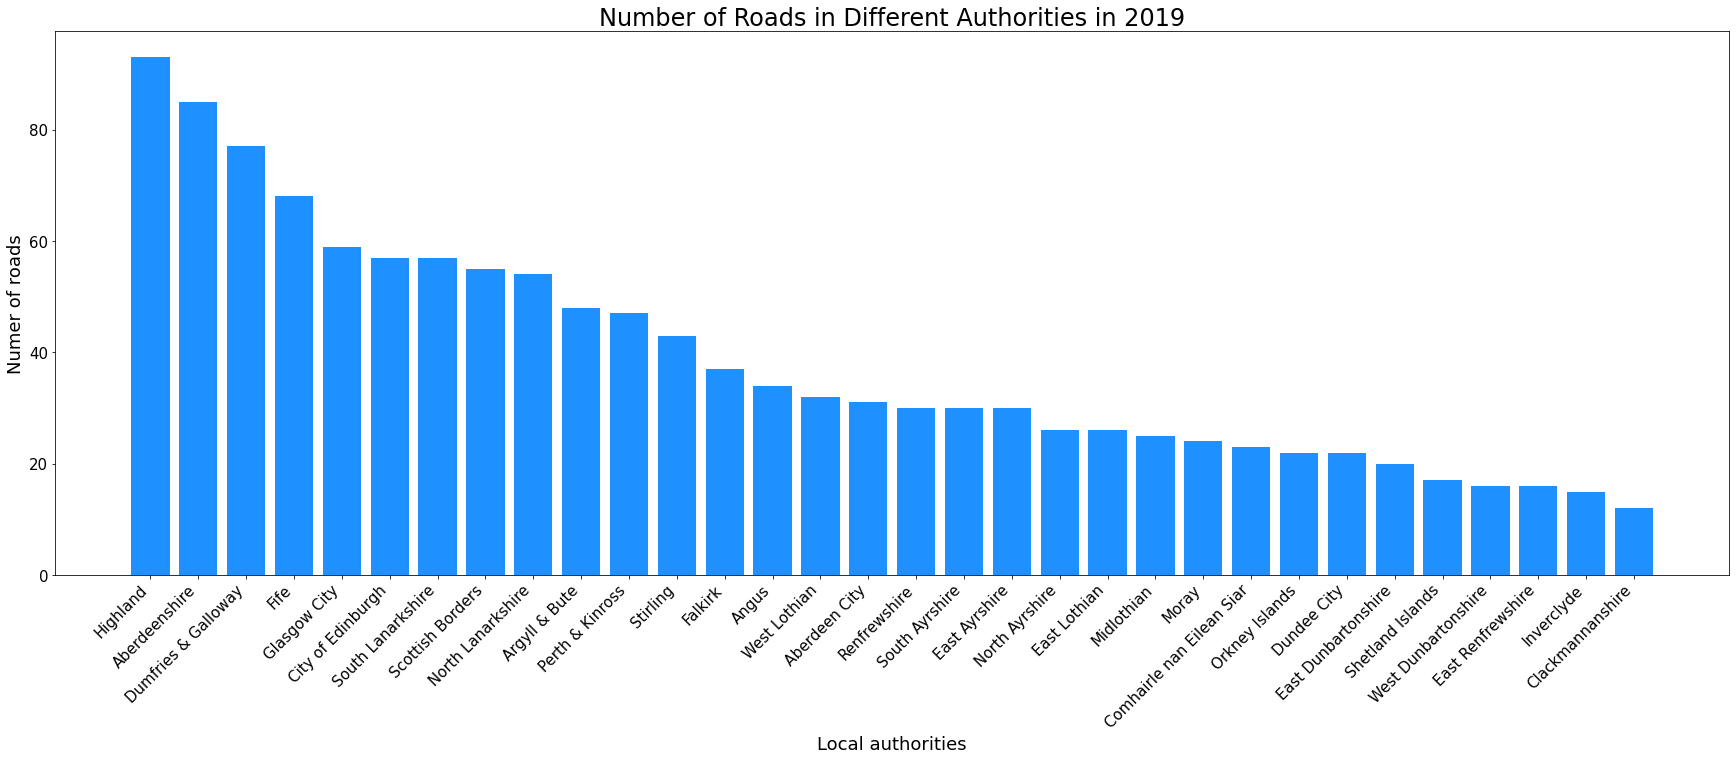

In [22]:
# References:
# Line 11: Matplotlib document
# URL1: https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.axes.Axes.set_xticks.html#matplotlib.axes.Axes.set_xticks
# URL2: https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.axes.Axes.set_xticklabels.html
# URL3: https://matplotlib.org/3.3.3/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py
# Accessed on 25 Nov 2020.

# Line 12: Matplotlib document
# URL: https://matplotlib.org/3.3.2/api/_as_gen/matplotlib.axes.Axes.tick_params.html
# Accessed on 25 Nov 2020.

# Make a bar plot to present the results
fig, ax = plt.subplots(figsize=(30,10))
ax.bar(road_autho_fv.index, road_autho_fv['Total_road_number'], color='dodgerblue')
ax.set_xlabel('Local authorities', fontsize=18)
ax.set_ylabel('Numer of roads', fontsize=18)
ax.set_title('Number of Roads in Different Authorities in 2019', fontsize=24)
# Specify the contents of xticklables
labels_x = road_autho_fv.index
# This step is to make the x tick labels rotate 45 dgree so that they will not get overlapped
# 'ha' means 'horizontalalignment' that controls the location of x tickle labels 
ax.set_xticklabels(labels_x, rotation=45, ha='right')
# The following line of code is to adjust the label sizes of both x and y major ticks
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

In [23]:
# Group the dataframe by local_authority_name and road_name
road_length_autho = pd.DataFrame(road_length.groupby(['local_authority_name','road_name']).link_length_miles.sum())
# Caluculate the total length of roads in each authority
total_length_autho = pd.DataFrame(road_length_autho.groupby('local_authority_name').link_length_miles.sum())
# Sort the dataframe by the value of link length
total_length_autho = total_length_autho.sort_values(by=['link_length_miles'], ascending=False)

In [24]:
# Display the results
total_length_autho.head()

link_length_miles
local_authority_name                   
Highland                        1486.41
Aberdeenshire                    560.36
Dumfries & Galloway              539.06
Argyll & Bute                    498.42
Perth & Kinross                  404.64

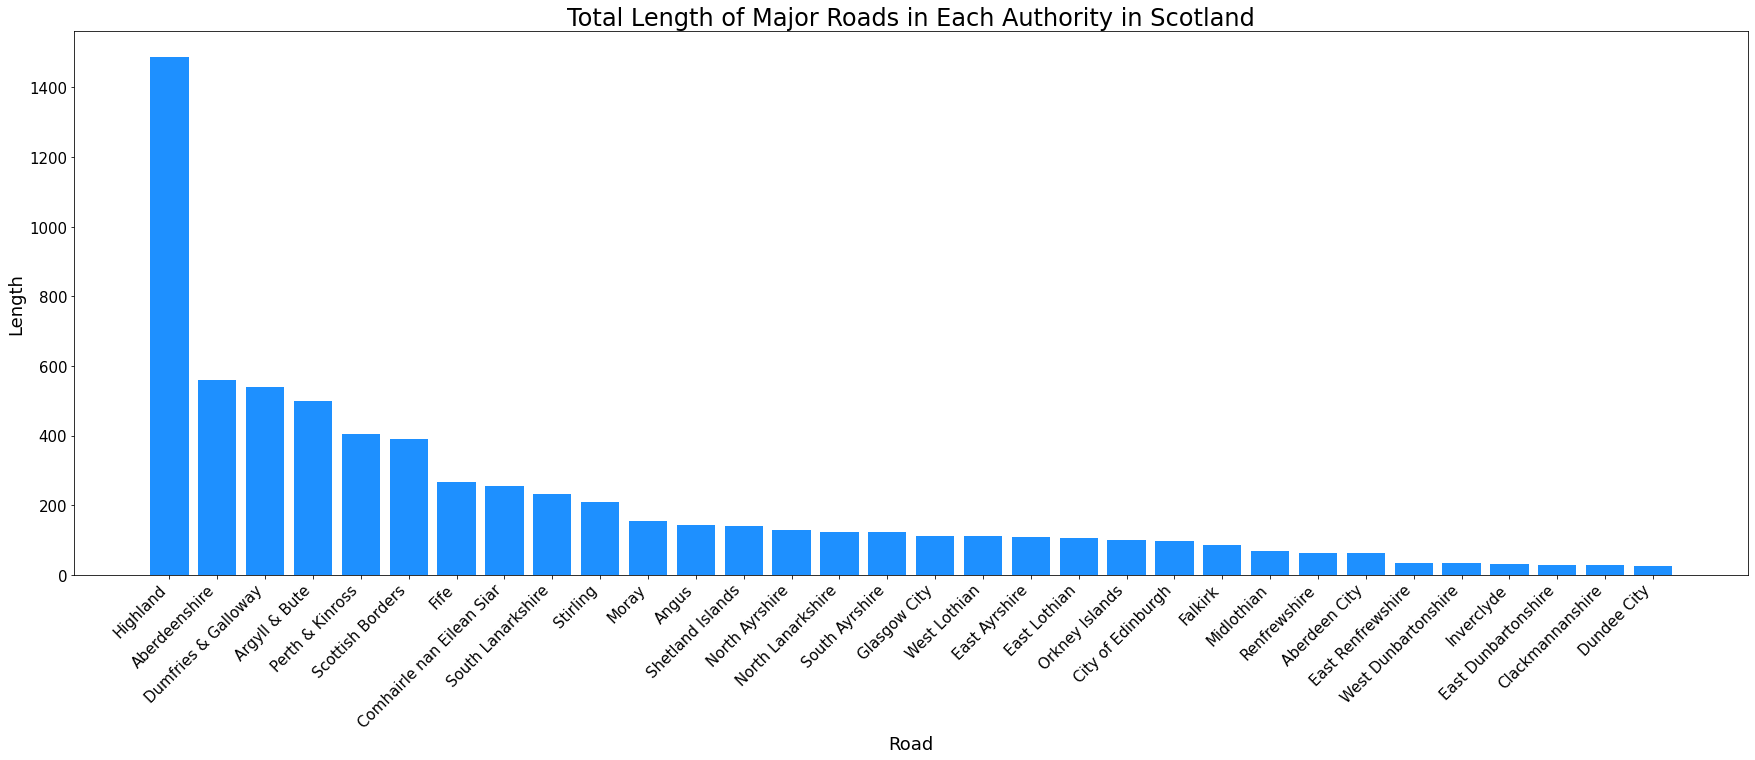

In [25]:
# Make a bar plot to present the total length of roads in each authority
fig, ax = plt.subplots(figsize=(30,10))
ax.bar(total_length_autho.index, total_length_autho['link_length_miles'], color='dodgerblue')
ax.set_xlabel('Road', fontsize=18)
ax.set_ylabel('Length', fontsize=18)
ax.set_title('Total Length of Major Roads in Each Authority in Scotland', fontsize=24)
labels_x = total_length_autho.index
ax.set_xticklabels(labels_x, rotation=45, ha='right')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

In [26]:
# Reference:
# Line 14-15: Anurag Uniyal
# URL: https://stackoverflow.com/questions/12965203/how-to-get-json-from-webpage-into-python-script
# Accessed on 29 Nov 2020.

# Get the url with data(json form) of each local authority in Scotland
# The file can be found on this website: https://martinjc.github.io/UK-GeoJSON/
url = 'https://raw.githubusercontent.com/martinjc/UK-GeoJSON/master/json/administrative/sco/lad.json'

# It is likely that the local authority names used in the json file does not perfectly match the names we use in the dataset
# Therefore, we need to extract the names from the url and compare them with names in the dataset

# Open the url and load the data from the url
response = urllib.request.urlopen(url)
data = json.loads(response.read())

# Create an empty list to store the local authority names in the json file
local_authority_names = []
# We find that the item 'LAD13NM' under 'properties' in each feature stores the name of each local authority
# Loop over all the features to get all the names
for index in range(len(data['features'])):
    local_authority_names.append(data['features'][index]['properties']['LAD13NM'])

# Display the results
local_authority_names

['Clackmannanshire',
 'Dumfries and Galloway',
 'East Ayrshire',
 'East Lothian',
 'East Renfrewshire',
 'Eilean Siar',
 'Falkirk',
 'Fife',
 'Highland',
 'Inverclyde',
 'Midlothian',
 'Moray',
 'North Ayrshire',
 'Orkney Islands',
 'Perth and Kinross',
 'Scottish Borders',
 'Shetland Islands',
 'South Ayrshire',
 'South Lanarkshire',
 'Stirling',
 'Aberdeen City',
 'Aberdeenshire',
 'Argyll and Bute',
 'City of Edinburgh',
 'Renfrewshire',
 'West Dunbartonshire',
 'West Lothian',
 'Angus',
 'Dundee City',
 'North Lanarkshire',
 'East Dunbartonshire',
 'Glasgow City']

In [27]:
# Reset the index of two dataframes that we will use and display the results
road_autho_fv1 = road_autho_fv.reset_index()
road_autho_fv1.head()

local_authority_name  M/A/B_road_number  U/C_raod_number  Total_road_number
0             Highland                 64               29                 93
1        Aberdeenshire                 36               49                 85
2  Dumfries & Galloway                 45               32                 77
3                 Fife                 35               33                 68
4         Glasgow City                 28               31                 59

In [28]:
total_length_autho1 = total_length_autho.reset_index()
total_length_autho1.head()

local_authority_name  link_length_miles
0             Highland            1486.41
1        Aberdeenshire             560.36
2  Dumfries & Galloway             539.06
3        Argyll & Bute             498.42
4      Perth & Kinross             404.64

In [29]:
# Check if there is any local authority name in the dataframe that does not show in json file
# Check the length
print(len(local_authority_names))
# Get the names and their indexes not included in the json file
for index in range(len(road_autho_fv1['local_authority_name'])):
    if road_autho_fv1.iloc[index, 0] not in local_authority_names:
        print('index: '+str(index)+' and the name: '+str(road_autho_fv1.iloc[index, 0]))

32
index: 2 and the name: Dumfries & Galloway
index: 9 and the name: Argyll & Bute
index: 10 and the name: Perth & Kinross
index: 23 and the name: Comhairle nan Eilean Siar


In [30]:
# Change the forms of names in dataframes
road_autho_fv1.iloc[2, 0] = 'Dumfries and Galloway'
road_autho_fv1.iloc[9, 0] = 'Argyll and Bute'
road_autho_fv1.iloc[10, 0] = 'Perth and Kinross'
road_autho_fv1.iloc[23, 0] = 'Eilean Siar'

total_length_autho1.loc['Dumfries & Galloway', 0] = 'Dumfries and Galloway'
total_length_autho1.loc['Argyll & Bute', 0] = 'Argyll and Bute'
total_length_autho1.loc['Perth & Kinross', 0] = 'Perth and Kinross'
total_length_autho1.loc['Comhairle nan Eilean Siar', 0] = 'Eilean Siar'

In [ ]:
# References:
# Line 19-31, 41-53: folium documentation
# URL: https://python-visualization.github.io/folium/modules.html
# Accessed on 29 Nov 2020.

# Line 35-37, 56-57: Amanda Iglesias Moreno
# URL: https://towardsdatascience.com/choropleth-maps-with-folium-1a5b8bcdd392
# Accessed on 29 Nov 2020.

# Create an empty map 
map_authority = folium.Map(location=[55.9533456,-3.1883749], zoom_start=12)
# Create a base map just like the code in one of the previous cells
base_map1 = folium.FeatureGroup(name='Basemap', overlay=True, control=False)
folium.TileLayer(tiles='OpenStreetMap').add_to(base_map1)
base_map1.add_to(map_authority)

# Create the choropleth map to show the road number on each local authority
# Parameters are selectively set according to folium documentation
roads_number = folium.Choropleth(
    geo_data=url,
    data=road_autho_fv1,
    columns=['local_authority_name', 'Total_road_number'],
    key_on='feature.properties.LAD13NM',
    fill_color='YlGn',
    fill_opacity=0.5,
    line_opacity=0.2,
    legend_name='The Number of Roads',
    highlight=True,
    name='The Number of Roads',
    overlay=False,
    show=False).add_to(map_authority)

# Set the style of the labels in the choropleth map
# Add labels to the choropleth map
style_function = "font-size: 15px; font-weight: bold"
roads_number.geojson.add_child(
    folium.features.GeoJsonTooltip(['LAD13NM'], style=style_function, labels=False))

# Create the choropleth map to show the total major road length on each local authority
# Parameters are set according to folium documentation
roads_length = folium.Choropleth(
    geo_data=url,
    data=total_length_autho1,
    columns=['local_authority_name', 'link_length_miles'],
    key_on='feature.properties.LAD13NM',
    fill_color='BuPu',
    fill_opacity=0.5,
    line_opacity=0.2,
    legend_name='The Length of Roads',
    highlight=True,
    name='The Length of Roads',
    overlay=False,
    show=False).add_to(map_authority)

# Add labels to the choropleth map
roads_length.geojson.add_child(
    folium.features.GeoJsonTooltip(['LAD13NM'], style=style_function, labels=False))

# Add layers to the empty map
folium.LayerControl().add_to(map_authority)
# Save the map as html file
map_authority.save('Local Authority Map.html')
# Display the map (the button at the up right corner can be used to switch layers)
map_authority

## Conclusions:
- From the choropleth maps above, we can see that Highland has the largest number of roads and highest major road length and that its total major road length is far higher than other local authorities. Aberdeenshire has the the second largest number of roads and major road length, and Dumfries & Galloway ranks the third. The City of Edinburgh and City of Glasgow have relatively large number of roads, but their total major road lengths are at the middle level.
- We infer that the number of roads and total road length are influenced by factors such as the area, population, the level of economic development, etc. 

## Limitations:
- As there is no link length for minor roads, we can only calculate and analyze the total length of major roads in each local authority. 

## 4. The Analysis of Annual Traffic Volume by Vehicle Type in 2000-2019 
🚩```Analysis Questions```
- What is the annual traffic volume of each type of vehicles (including two-wheeled motor vehicles, cars and taxis, buses and coaches, light goods vans, all heavy good vehicles and the total motor vehicles) from 2000 and 2019?
- What is the future trend of the total traffic volume in Scotland? Forecast the total traffic volume in the next 5 years.

📚```Methodology```
- How we calculate the annual traffic volume of each type of vehicles?
    - There are two types of roads in Scotland which are main road and minor road. Since there are not enough data collected for minor roads, we will put more emphasis on the calculating the traffic volume on the major roads.
    - According to the methodology notes provided by Department for Transportation:
        - the first step is to calculate annual average daily flow (AADF) which is the number of vehicles estimated to pass a given point on the road in a 24-hour period on an average day in the year.
        - The second step is that we need to convert the AADF into traffic volume. We multiply each AADF with its associated link length(miles), and then multiply it by the number of days in the year to get an annual total.   
    - However, when calculating the AADF, we find that the number of counting points of each year varied drastically, so at first, we try to calculate the AADF by calculating the average traffic volume of each year and then multiply the largest number of counting points. As the first line chart (Original Annual traffic volume in Scotland from 2000 to 2019) shown, it is still unavoidable to have some extremums.
     - Hence, to fix and adjust these extremums to make our statistical data fairer, we replaced these with the regular and organized historical data to estimate these extremums. The results are shown on the second line chart (Adjusted Annual traffic volume in Scotland from 2000 to 2019), which looks smoother than the previous one.
    - The function is
$$
Traffic_{CP}= AADF_{CP}\times Length\ Link\times 365
$$

$$
Total\ Traffic =\sum_{i=0}^{n}Traffic_{CP}
$$
[Reference for the Total Traffic methodology](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/524848/annual-methodology-note.pdf)
(Accessed date: Nov 28, 2020)

- How we predict the trends of the coming 5 years?
    - In statistics and in particular in time series analysis, the autoregressive integrated moving average (ARIMA) model is fitted to time series data either to better understand the data or to predict future points in the series forecasting. Therefore, we import ARIMA from statsmodel.tsa.arima_model and simplified the model to complete the prediction more conveniently.

[Reference for the prediction(1)](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average)
[Reference for the prediction(2)](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html)
(Accessed date: Nov 27, 2020)


In [32]:
# Extract the data of major roads and discard the missing lines missing data
variable_list4 = ['count_point_id', 'year', 'road_name', 'road_type', 'link_length_miles','pedal_cycles', 'two_wheeled_motor_vehicles', 'cars_and_taxis', 'buses_and_coaches', 'lgvs', 'all_hgvs', 'all_motor_vehicles']
road_major = total_frame.loc[:,variable_list4]
data_major = road_major[road_major['road_type'].isin(['Major']) & ~road_major['link_length_miles'].isin([0])]
data_major

count_point_id  year road_name road_type  link_length_miles  \
183               1153  2019      A905     Major               0.68   
184               1153  2019      A905     Major               0.68   
185               1153  2019      A905     Major               0.68   
186               1153  2019      A905     Major               0.68   
187               1153  2019      A905     Major               0.68   
...                ...   ...       ...       ...                ...   
276859           80605  2000       M90     Major               1.30   
276860           80605  2000       M90     Major               1.30   
276861           80605  2000       M90     Major               1.30   
276862           80605  2000       M90     Major               1.30   
276863           80605  2000       M90     Major               1.30   

        pedal_cycles  two_wheeled_motor_vehicles  cars_and_taxis  \
183                0                           0             428   
184                0                           0             382   
185                0                           3             494   
186                0                           0             204   
187                0                           3             611   
...              ...                         ...             ...   
276859             6                           8             357   
276860             1                           9             491   
276861             1                           5             668   
276862             1                           3             922   
276863             2                           3             610   

        buses_and_coaches  lgvs  all_hgvs  all_motor_vehicles  
183                     1    89        75                 593  
184                     2    98        80                 562  
185                     0    47        17                 561  
186                     1    42        40                 287  
187                     3   136        63                 816  
...                   ...   ...       ...                 ...  
276859                 36    41       100                 542  
276860                 32    42       106                 680  
276861                 30   128        58                 889  
276862                 21    74        41                1061  
276863                 10    62        31                 716  

[130084 rows x 12 columns]

In [33]:
# Calculate link_length_miles times the number of each type of vehicles
data_major['multiply_all_motor_vehicles'] = data_major['link_length_miles'] * data_major['all_motor_vehicles']
data_major['multiply_two_wheeled_motor_vehicles']= data_major['link_length_miles'] * data_major['two_wheeled_motor_vehicles']
data_major['multiply_cars_and_taxis']= data_major['link_length_miles'] * data_major['cars_and_taxis']
data_major['multiply_buses_and_coaches']= data_major['link_length_miles'] * data_major['buses_and_coaches']
data_major['multiply_lgvs']= data_major['link_length_miles'] * data_major['lgvs']
data_major['multiply_all_hgvs']= data_major['link_length_miles'] * data_major['all_hgvs']
data_major['multiply_pedal_cycles']= data_major['link_length_miles'] * data_major['pedal_cycles']
variable_list5 = ['count_point_id', 'road_name', 'year', 'multiply_all_motor_vehicles', 'multiply_two_wheeled_motor_vehicles', 
                  'multiply_cars_and_taxis', 'multiply_buses_and_coaches', 'multiply_lgvs', 'multiply_all_hgvs', 'multiply_pedal_cycles']
data_major2 = data_major.reindex(columns = variable_list5)
data_major2.head()

count_point_id road_name  year  multiply_all_motor_vehicles  \
183            1153      A905  2019                       403.24   
184            1153      A905  2019                       382.16   
185            1153      A905  2019                       381.48   
186            1153      A905  2019                       195.16   
187            1153      A905  2019                       554.88   

     multiply_two_wheeled_motor_vehicles  multiply_cars_and_taxis  \
183                                 0.00                   291.04   
184                                 0.00                   259.76   
185                                 2.04                   335.92   
186                                 0.00                   138.72   
187                                 2.04                   415.48   

     multiply_buses_and_coaches  multiply_lgvs  multiply_all_hgvs  \
183                        0.68          60.52              51.00   
184                        1.36          66.64              54.40   
185                        0.00          31.96              11.56   
186                        0.68          28.56              27.20   
187                        2.04          92.48              42.84   

     multiply_pedal_cycles  
183                    0.0  
184                    0.0  
185                    0.0  
186                    0.0  
187                    0.0

In [34]:
# Calculate the total numbers of counting points of each year
data_count = pd.DataFrame(data_major2.groupby(['year'])['count_point_id'].nunique())

# Put the counts of each year to a list
list_data_count = []
for i in data_count:
    list_data_count.append(i)  
    
data_count

count_point_id
year                
2000             325
2001             312
2002             307
2003             426
2004             434
2005             371
2006             421
2007             406
2008             429
2009             426
2010             167
2011             281
2012             292
2013             239
2014              45
2015              82
2016              85
2017              79
2018             151
2019             150

In [35]:
# Group data by years and sum up the number of vehicles counted
data_major_grouped = pd.DataFrame(data_major.groupby('year')['multiply_all_motor_vehicles', 'multiply_two_wheeled_motor_vehicles', 'multiply_cars_and_taxis', 'multiply_buses_and_coaches', 'multiply_lgvs', 'multiply_all_hgvs', 'multiply_pedal_cycles'].sum())
# Merge two dataframes (data_major_grouped and data_count)
traffic_volume_data = pd.merge(data_major_grouped, data_count, on='year')
# Display the merged dataframe
traffic_volume_data.head()

multiply_all_motor_vehicles  multiply_two_wheeled_motor_vehicles  \
year                                                                     
2000                  10004484.73                             42806.46   
2001                   9694602.41                             43526.77   
2002                   9784873.08                             54517.96   
2003                  14625605.86                             74388.89   
2004                  13857303.61                             67747.50   

      multiply_cars_and_taxis  multiply_buses_and_coaches  multiply_lgvs  \
year                                                                       
2000               7727976.08                   132511.25     1074825.97   
2001               7471420.78                   121219.79     1061437.33   
2002               7616838.68                   145350.98     1121537.49   
2003              11148707.66                   162848.42     1725204.50   
2004              10507537.12                   165378.42     1657595.78   

      multiply_all_hgvs  multiply_pedal_cycles  count_point_id  
year                                                            
2000         1026364.97               15068.99             325  
2001          996997.74                9696.01             312  
2002          846627.97               14936.70             307  
2003         1514456.39               14766.63             426  
2004         1459044.79               13582.13             434

In [36]:
# Calcualte the traffic volume of each vehicle and replace the number of vehicles in traffic_volume_data with traffic volume data
for column in traffic_volume_data.columns[:-1]:
    traffic_volume_data[column] = traffic_volume_data[column] * 365 / traffic_volume_data['count_point_id'] * np.max(traffic_volume_data['count_point_id'])

In [37]:
# Round the data in traffic_volume_data and change its column names
traffic_volume_data = traffic_volume_data.round()
traffic_volume_data.columns = ['all_motor_vehicles', 'two_wheeled_motor_vehicles', 'cars_and_taxis', 
                               'buses_and_coaches', 'lgvs', 'all_hgvs', 'pedal_cycles', 'count_point_number']
traffic_volume_data.head()

all_motor_vehicles  two_wheeled_motor_vehicles  cars_and_taxis  \
year                                                                   
2000        4.876340e+09                  20864527.0    3.766734e+09   
2001        4.922186e+09                  22099601.0    3.793422e+09   
2002        5.048931e+09                  28130912.0    3.930239e+09   
2003        5.438597e+09                  27661841.0    4.145697e+09   
2004        5.057916e+09                  24727838.0    3.835251e+09   

      buses_and_coaches         lgvs     all_hgvs  pedal_cycles  \
year                                                              
2000         64588022.0  523886714.0  500266077.0     7344858.0   
2001         61546240.0  538917588.0  506200038.0     4922900.0   
2002         75000159.0  578706038.0  436854517.0     7707240.0   
2003         60555911.0  641524988.0  563157363.0     5491037.0   
2004         60363123.0  605022460.0  532551348.0     4957477.0   

      count_point_number  
year                      
2000                 325  
2001                 312  
2002                 307  
2003                 426  
2004                 434

In [38]:
# Plotting
# Line 6, 10-14, 15: code about plotly
# URL:https://plotly.com/python/line-charts/
# Accessed on 28 Nov 2020.

fig = go.Figure()
# Loop over each column (except the last one) to make the plot of the traffic volume of each vehicle type
for column in traffic_volume_data.columns[:-1]:
    x = traffic_volume_data.index
    fig.add_trace(go.Scatter(x=x, y=traffic_volume_data[column],
                  mode='lines+markers',
                  name=str(column)))
fig.update_layout(title_text='Original Annual Traffic Volume in Scotland from 2000 to 2019')
# Put the plot into a html file and open it automatically
fig.write_html('Original Annual Traffic Volume in Scotland from 2000 to 2019.html', auto_open=True)
fig.show()   

```Adjust extreme values```
- As we can see from the plot above, there were drastic changes after 2010, we suspect that this is because of counting errors and more reliance on ATCs.

- To eliminate these factors and get a more smooth line chart, we adjusted some outliers and replace these extreme values with the averages on the basis of historial data.

- After oberservation, the data of first 5 years are basically normal and shows a general rising tendency. Hence, we will try to adjust extreme values in 2009,2010,2011,2012,2013,2015,2016 2018 and 2019 based on the data of the previous 5 years.

In [39]:
# Convert each pd.series to a list to better adjust data
list1 = list(traffic_volume_data['all_motor_vehicles'])
list2 = list(traffic_volume_data['two_wheeled_motor_vehicles'])
list3 = list(traffic_volume_data['cars_and_taxis'])
list4 = list(traffic_volume_data['buses_and_coaches'])
list5 = list(traffic_volume_data['lgvs'])
list6 = list(traffic_volume_data['all_hgvs'])
list7 = list(traffic_volume_data['pedal_cycles'])

In [40]:
# Adjust outliers in the dataset of two_wheeled_motor_vehicles
inc_01 = (list2[1] - list2[0]) / list2[0]
inc_12 = (list2[2] - list2[1]) / list2[1]
inc_23 = (list2[3] - list2[2]) / list2[2]
inc_34 = (list2[4] - list2[3]) / list2[3]

list2[4] = list2[3]*(1+inc_34)
list2[9] = list2[8]*(1+inc_23)
list2[10] = list2[9]*(1+inc_01)
list2[11] = list2[10]*(1+inc_23)
list2[12] = list2[10]*(1+inc_23)
list2[13] = list2[10]*(1+inc_34)
list2[14] = list2[10]*(1+inc_01)
list2[15] = list2[10]*(1+inc_23)
list2[16] = list2[10]*(1+inc_34)
list2[17] = list2[10]*(1+inc_01)
list2[18] = list2[10]*(1+inc_01)
list2[19] = list2[10]*(1+inc_23)

In [41]:
# Ajust outliers in the dataset of cars_and_taxis
inc_01 = (list3[1] - list3[0]) / list3[0]
inc_12 = (list3[2] - list3[1]) / list3[1]
inc_23 = (list3[3] - list3[2]) / list3[2]
inc_34 = (list3[4] - list3[3]) / list3[3]
list3[4] = list3[3]*(1+inc_23)
list3[9] = list3[8]*(1+inc_01)
list3[10] = list3[9]*(1+inc_01)
list3[11] = list3[10]*(1+inc_23)
list3[12] = list3[10]*(1+inc_12)
list3[13] = list3[10]*(1+inc_23)
list3[14] = list3[10]*(1+inc_01)
list3[15] = list3[10]*(1+inc_12)
list3[16] = list3[10]*(1+inc_01)
list3[17] = list3[10]*(1+inc_23)
list3[18] = list3[10]*(1+inc_23)
list3[19] = list3[10]*(1+inc_23)

In [42]:
# Ajust outliers in the dataset of buses_and_coaches
inc_01 = (list4[1] - list4[0]) / list4[0]
inc_12 = (list4[2] - list4[1]) / list4[1]
inc_23 = (list4[3] - list4[2]) / list4[2]
inc_34 = (list4[4] - list4[3]) / list4[3]

list4[4] = list4[3]*(1+inc_01)
list4[9] = list4[8]*(1+inc_23)
list4[10] = list4[9]*(1+inc_23)
list4[11] = list4[10]*(1+inc_34)
list4[12] = list4[10]*(1+inc_12)
list4[13] = list4[10]*(1+inc_12)
list4[14] = list4[10]*(1+inc_23)
list4[15] = list4[10]*(1+inc_34)
list4[16] = list4[10]*(1+inc_01)
list4[17] = list4[10]*(1+inc_12)
list4[18] = list4[10]*(1+inc_01)
list4[19] = list4[10]*(1+inc_23)

In [43]:
# Ajust outliers in the dataset of lgvs
inc_01 = (list5[1] - list5[0]) / list5[0]
inc_12 = (list5[2] - list5[1]) / list5[1]
inc_23 = (list5[3] - list5[2]) / list5[2]
inc_34 = (list5[4] - list5[3]) / list5[3]

list5[4] = list5[3]*(1+inc_23)
list5[9] = list5[8]*(1+inc_34)
list5[10] = list5[9]*(1+inc_23)
list5[11] = list5[10]*(1+inc_12)
list5[12] = list5[10]*(1+inc_01)
list5[13] = list5[10]*(1+inc_12)
list5[14] = list5[10]*(1+inc_23)
list5[15] = list5[10]*(1+inc_34)
list5[16] = list5[10]*(1+inc_01)
list5[17] = list5[10]*(1+inc_12)
list5[18] = list5[10]*(1+inc_01)
list5[19] = list5[10]*(1+inc_23)


In [44]:
# Ajust outliers in the dataset of all_hgvs
inc_01 = (list6[1] - list6[0]) / list6[0]
inc_12 = (list6[2] - list6[1]) / list6[1]
inc_23 = (list6[3] - list6[2]) / list6[2]
inc_34 = (list6[4] - list6[3]) / list6[3]

list6[4] = list5[3]*(1+inc_23)
list6[9] = list5[8]*(1+inc_34)
list6[10] = list5[9]*(1+inc_23)
list6[11] = list5[10]*(1+inc_12)
list6[12] = list5[10]*(1+inc_01)
list6[13] = list5[10]*(1+inc_12)
list6[14] = list5[10]*(1+inc_23)
list6[15] = list5[10]*(1+inc_34)
list6[16] = list5[10]*(1+inc_01)
list6[17] = list5[10]*(1+inc_12)
list6[18] = list5[10]*(1+inc_01)
list6[19] = list5[10]*(1+inc_23)

# Sum up data above to get a list of data for all_motor_vehicles (not including pedal cycles)
list1 = []
for i in range(0,20):
    list1.append(list2[i] + list3[i] + list4[i] + list5[i] + list6[i])

In [45]:
# Line 1, 10-15: code about plotly
# URL:https://plotly.com/python/line-charts/
# Accessed on 28 Nov 2020.

# Make the plot for adjusted data
fig1 = go.Figure()
lists = [list1, list2, list3, list4, list5, list6, list7]
columns_name = traffic_volume_data.columns[:-1]
for i in range(len(lists)):
    x = traffic_volume_data.index
    fig1.add_trace(go.Scatter(x=x, y=lists[i],
                  mode='lines+markers',
                  name=str(columns_name[i])))
fig1.update_layout(title_text='Adjusted Annual Traffic Volume in Scotland from 2000 to 2019')
fig1.write_html('Ajusted Annual Traffic Volume in Scotland from 2000 to 2019.html', auto_open=True)
fig1.show()   

In [46]:
# Put the adjusted data into a new dataframe
data = {}
for i in range(len(lists)):
    data[columns_name[i]] = lists[i]
traffic_volume_pred = pd.DataFrame(data, index=[x])
traffic_volume_pred_copy = pd.DataFrame(data, index=[x])
traffic_volume_pred.head()

all_motor_vehicles  two_wheeled_motor_vehicles  cars_and_taxis  \
year                                                                   
2000        4.876340e+09                  20864527.0    3.766734e+09   
2001        4.922186e+09                  22099601.0    3.793422e+09   
2002        5.048931e+09                  28130912.0    3.930239e+09   
2003        5.438597e+09                  27661841.0    4.145697e+09   
2004        5.993562e+09                  24727838.0    4.372966e+09   

      buses_and_coaches          lgvs      all_hgvs  pedal_cycles  
year                                                               
2000       6.458802e+07  5.238867e+08  5.002661e+08     7344858.0  
2001       6.154624e+07  5.389176e+08  5.062000e+08     4922900.0  
2002       7.500016e+07  5.787060e+08  4.368545e+08     7707240.0  
2003       6.055591e+07  6.415250e+08  5.631574e+08     5491037.0  
2004       5.770402e+07  7.111630e+08  8.270019e+08     4957477.0

In [47]:
# Line 6: statsmodels.tsa.stattools
# URL: https://tedboy.github.io/statsmodels_doc/generated/statsmodels.tsa.base.datetools.dates_from_range.html
# Accessed on 28 Nov 2020.

# Convert the form of the index of the adjusted traffic volume dataframe to datetime
traffic_volume_pred.index = pd.Index(sm.tsa.datetools.dates_from_range('2000','2019'))
traffic_volume_pred.head()

all_motor_vehicles  two_wheeled_motor_vehicles  cars_and_taxis  \
2000-12-31        4.876340e+09                  20864527.0    3.766734e+09   
2001-12-31        4.922186e+09                  22099601.0    3.793422e+09   
2002-12-31        5.048931e+09                  28130912.0    3.930239e+09   
2003-12-31        5.438597e+09                  27661841.0    4.145697e+09   
2004-12-31        5.993562e+09                  24727838.0    4.372966e+09   

            buses_and_coaches          lgvs      all_hgvs  pedal_cycles  
2000-12-31       6.458802e+07  5.238867e+08  5.002661e+08     7344858.0  
2001-12-31       6.154624e+07  5.389176e+08  5.062000e+08     4922900.0  
2002-12-31       7.500016e+07  5.787060e+08  4.368545e+08     7707240.0  
2003-12-31       6.055591e+07  6.415250e+08  5.631574e+08     5491037.0  
2004-12-31       5.770402e+07  7.111630e+08  8.270019e+08     4957477.0

In [48]:
# Add up the traffic volume of all motor vehicles and pedal cycles
ttv = traffic_volume_pred['all_motor_vehicles'] + traffic_volume_pred['pedal_cycles']

In [49]:
# Line 18: statsmodels.tsa.stattools
# URL: https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html
# Accessed on 28 Nov 2020.

def teststationarity(data):
    '''
    This function is to test the stationarity of data input by ADF test.
    
    Input:
    data (pd.series): the data that we want to test.
    
    Output:
    result_description (pd.series): the description of ADF test result.
    '''
    # Call the ADF test function, the function is mainly used to test the stationarity of data series.
    # The following are several critical outputs, for simplicity, we can see whether p-vaue is higher than 0.01 to determine the data's stationarity.
    dftest = ADF(data)
    # Gather necessary information
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value ('+str(key)+'):'] = value
    return dfoutput 

In [50]:
# Line 24: pandas
# URL: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.diff.html
# Accessed on 28 Nov 2020.

def diff(data, time):
    '''
    This function is to make the data more stationary by conducting difference transformation.
    We firstly calculate the difference between one item and its next item: a_n+1 - a_n;
    then do the same thing to the difference data again and agian and...(depending on the parameter, time)
    
    Input:
    data (pd.series): the original data.
    
    Output:
    data_diff (pd.series): the processed data.
    '''
    # Create an empty list to store the first 'time' data, for example, 2 values when difference methods used twice
    first_values = []
    # Perform difference method 'time' times
    for i in range(1,time+1):
        first_values.append(pd.Series([data[0]],index=[data.index[0]]))
        # Get the difference between the item with its next item (a_n+1 - a_n)
        data_diff = data.diff(1).dropna()
        data = data_diff
    return first_values, data_diff

In [51]:
def shift(first_values, data):
    '''
    This function is to reverse the series after conducting difference transformations to get the original data.

    Input:
    data (pd.series): the processed data.
    
    Output:
    data_recover (pd.series): the original data.
    '''
    data_recover = data
    # Recover the data len(first_values) times
    for first in reversed(first_values):
        # Use cumsum() to recover the data
        data_recover = first.append(data_recover).cumsum()
    return data_recover

In [52]:
# Line 17, 19: statsmodels.graphics
# URL: https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html
# Accessed on 28 Nov 2020.

def plots(data):
    '''
    This function is to make autocorrelation plots and partial correlation plots.

    Input:
    data (pd.series): the data used to make the plots.

    Output:
    None
    '''
    fig = plt.figure(figsize=(8,8))
    ax1 = fig.add_subplot(211)
    plot_acf(data,ax=ax1)
    ax2 = fig.add_subplot(212)
    plot_pacf(data,ax=ax2)
    plt.subplots_adjust(hspace=0.3)
    plt.show()
    return None

In [53]:
# Line 19-20, 22: statsmodels.tsa
# URL: https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html
# Accessed on 28 Nov 2020.

def forecasts(original_data, time, order, steps):
    '''
    This function is to make forecasts of traffic volume after 2019 by ARIMA model, then recover the values using shift function (if any difference transformations are used), lastly append forecasts to the original time series data. 

    Input:
    original_data (pd.series): the original dataset before any transformations made.
    time (int): how many times we want to do difference transformations to the original data.
    order ((p, d, q), p, d, q is int): the order of ARIMA model that we want to use.
    steps (int): how many steps that we want predict.

    Output:
    forecast_data (pd.series): a pd.series contains both the original data and forecast data.
    '''
    # Call the ARIMA model
    model = ARIMA(diff(original_data, time)[1], order=order)
    model_fit = model.fit(disp=0)
    # Get the forecast data
    forecasts = model_fit.forecast(steps=steps)[0]
    forecast_s = pd.Series(forecasts)
    # Get the last two years' data (2018 and 2019) to help recover the forecast data 
    first_values = [pd.Series([original_data[18]],index=[original_data.index[18]])]
    first_values.append(pd.Series([original_data[19]-original_data[18]],index=[original_data.index[19]]))
    # Recover the data by shift function
    recover_forecast = shift(first_values, forecast_s)
    # Set the datetime index
    recover_forecast.index = pd.Index(sm.tsa.datetools.dates_from_range('2018',str(2020+steps-1)))
    # Append the forecast data (pd.series) to the original one
    forecast_data = original_data.append(recover_forecast[2:])
    return forecast_data

In [54]:
# Test stationarity
teststationarity(ttv)

Test Statistic                 -0.813576
p-value                         0.815102
Lags Used                       8.000000
Number of Observations Used    11.000000
Critical Value (1%):           -4.223238
Critical Value (5%):           -3.189369
Critical Value (10%):          -2.729839
dtype: float64

In [55]:
# Try to make the data more stationary by difference method
# Transforming the data twice can make the data become stationary
teststationarity(diff(ttv, 2)[1])

Test Statistic                 -5.138104
p-value                         0.000012
Lags Used                       0.000000
Number of Observations Used    17.000000
Critical Value (1%):           -3.889266
Critical Value (5%):           -3.054358
Critical Value (10%):          -2.666984
dtype: float64

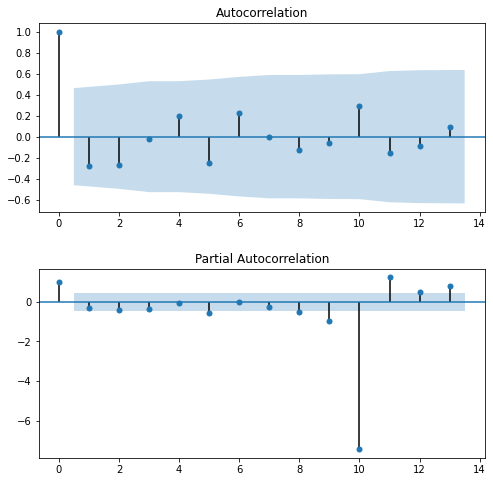

In [56]:
# Make plots to give us a general idea about what p and q should be
plots(diff(ttv, 2)[1])

In [57]:
# Call the forecasts function
# We set p = 2 mainly because of the lags in partial autocorrelation plot, usually 1 and 2 are used, in this case, we found that p = 2 make the forecasts more reasonable; q = 0 is because it is the only value that does not make the model fail here, errors would come out when other values were used.
fttv = forecasts(ttv, 2, (2, 2, 0), 6)
# We notice that the forcast data is a little bit of realitic life
# Especially we expect that Covid-19 will have impact the traffic volume in 2020
# Therefore, we want to adjust the forecast data a little bit to make them more convincing
fttv_adjust = forecasts(ttv, 2, (2, 2, 0), 6)
fttv

2000-12-31    4.883685e+09
2001-12-31    4.927109e+09
2002-12-31    5.056638e+09
2003-12-31    5.444088e+09
2004-12-31    5.998520e+09
2005-12-31    5.642529e+09
2006-12-31    5.493196e+09
2007-12-31    5.683016e+09
2008-12-31    6.031807e+09
2009-12-31    6.149489e+09
2010-12-31    6.478184e+09
2011-12-31    6.536611e+09
2012-12-31    6.549068e+09
2013-12-31    6.541987e+09
2014-12-31    6.699705e+09
2015-12-31    6.405596e+09
2016-12-31    6.396779e+09
2017-12-31    6.544280e+09
2018-12-31    6.633503e+09
2019-12-31    6.919715e+09
2020-12-31    7.256046e+09
2021-12-31    7.643450e+09
2022-12-31    8.174502e+09
2023-12-31    8.782374e+09
2024-12-31    9.519563e+09
2025-12-31    1.042303e+10
dtype: float64

In [58]:
# We estimate that the traffic volume in 2020 and 2021 would be about 73% of the forecast values by ARIMA and 75% in years afterwards
# One of the reasons that we adjust the data is that we believe that COVID-19 will impact the traffic volume in 2020 and 2021; meanwhile, with increasing environmental concerns, people may be willing to decrease the use of motor vehicles and cars and taxis
for i in range(20, 26):
    if i <= 21:
        fttv_adjust[i] = fttv[i]*0.73
    else:
        fttv_adjust[i] = fttv[i]*0.75

In [59]:
# Line 5, 12-14, 16-20: code about plotly
# URL:https://plotly.com/python/line-charts/
# Accessed on 28 Nov 2020.

fig_test = go.Figure()
# Create a list for x-axis lables
list_year_new = []
for i in range(2000,2030):
    list_year_new.append(i)
x = list_year_new
# Make the plot for historical data
fig_test.add_trace(go.Scatter(x=x, y=fttv_adjust,
                  mode='lines+markers',
                  name='Historical total traffic volume'))
# Make the plot for forecast data
fig_test.add_trace(go.Scatter(x=x[20:], y=fttv_adjust[20:],
                  mode='lines+markers',
                  name='Forecast total traffic volume'))
fig_test.update_layout(title_text='Prediction of Total Traffic Volume in Scotland')
fig_test.write_html('Prediction of Total Traffic Volume in Scotland.html', auto_open=True)
fig_test.show()  

## Conclusions:
#### 1. In general, there is a rising trend and it might continue in the future years.
- Accroding to the figure above, obviously there is a rising trend in the volume of total motors and vehicles from 2000 to 2019. Although we predict that Covid-19 may have impact on the traffic volume in 2020, the traffic volume might have a down for about two years.It might keep the upward tendency in the late 3 years.

#### 2. Rising business population boots the demand of vehicles.
- On the one hand, accroding to the statistics by National Statistics, the business population is rising among 2000 to 2020, from 3.5 million to 6.0 million. That indicates more and more people can afford to own vehicles, which causes the increasing of annual traffic volume.

(Source from URL: https://www.gov.uk/government/publications/business-population-estimates-2020/business-population-estimates-for-the-uk-and-regions-2020-statistical-release-html )

#### 3. With increasing environmental concerns，the growth rate of traffic volume might slow down.
- One the other hand, with the growth of environmental awareness, the growth rate of annual traffic volume might slow down and be more gentle.
   1. It is worth noting that the higher growth rate of two_wheeled_motor_vehicles than cars_and_taxis.The CAGR from 2000 to 2019 of two_wheeled_motor_vehicles equals to 2.65%. The same, the rate of cars_and_taxis equals to 1.22%. 
   
   2. From the growth rate, we can find that the volume of two_wheeled_motor_vehicles grows fast than cars_and_taxis, which means that people are more willing to choose some motor vehicles than traditional cars. There are some possible reasons for this phenomenon, the one is that people may think motors can save their time since the traffic jam, the other is that people want to pursue something fresh or fashion from the two_wheeled_motor_vehicles. So we adjusted the forecast values by ARIMA in years after 2021.

## Limitations:
#### 1. Data quality and availability: 
- The calculation of traffic volume is based on the data of number of vehicles counted at each count point and link lengths. When we processed the data, we found that the number of count points vary greatly in different years, leading to large fluctuations in the plot that we made. Therefore, we had to adjust the extreme values manually.

#### 2. ARIMA model:
- We noticed that the forecasts we got from ARIMA model were not so fair. Part of the reason is that we have a quite small dataset (only 20 historical values, and actually 18 values after conducting the difference method twice). In addition, the trend of previous data is quite complex, which can not be fully captured by certain seasonal patterns or trend patterns.
- In addition, we intended to predict the traffic volume of each vehicle type at first, but we noticed that the data of some vehicle types were too unstationary. In this case, it is not possible to use ARIMA model.


## 5. The Analysis of Annual Traffic Volume by Road Type in 2000-2019 
🚩```Analysis Questions```
- On an average day, what is the distribution of all motor vehicles on different road categories (A, M B, U, C roads)? Has this changed significantly over the years?

📚```Methodology```
- How we calculate the annual traffic volume for the major road:
    - Following the official document’s instruction, we use link_length_miles times all_motor_vehivles to get the value of multiply_all_motor_vehicles.
    - Then we multiply this value and the total number of days in a year, which is equal to 365 to get the annual traffic volume per road. 
    - Finally, we sum up the annual traffic volume grouped by year to get the annual traffic volume of all_motor_vehicles on type ‘A’ and ‘M’ road, respectively.

- How we calculate the annual traffic volume for the minor road:
   - For these kinds of minor roads, we cannot use the official methodology since there is no data of link_length_miles for these roads.
   - We choose another way: multiplying total known road length and all_motor_vehicles to approximate annual traffic volume.
   - We group these data by year and get the line chart of road ‘B’ and ‘U_C’ road, respectively.
   - Data reference https://www.gov.uk/government/statistical-data-sets/road-length-statistics-rdl

In [60]:
# Get data from the initial csv and an integrated excel
data_length = pd.read_csv('road_length.csv')
data_length = data_length.drop('Unnamed: 3', axis=1)

# Delete the empty data of 'Minor'
data_major = road_major[road_major['road_type'].isin(['Major']) & ~road_major['link_length_miles'].isin([0])]
# Get the data of minor road and use another method to calculate the traffic volume of "B" and "U_C_road"
data_minor = road_major[road_major['road_type'].isin(['Minor'])]
# Screen out the data of 'road_name' which contains all of the road name starting with 'A'
A_road = data_major[data_major['road_name'].str.contains("A")]
# Screen out the data of 'road_name' which contains all of the road name starting with 'M'
M_road = data_major[data_major['road_name'].str.contains("M")]
# Screen out the data of 'road_name' which contains all of the road name starting with 'B'
B_road = data_minor[data_minor['road_name'].str.contains("B")]
# Screen out the data of 'road_name' which contains all of the road name starting with 'U' and 'C'
x = pd.Series(['U', 'C'])
U_C_road = pd.DataFrame(data_minor.loc[data_minor['road_name'] == x.any(), ['year', 'all_motor_vehicles']])

# Calculate link_length_miles times the number of all motor vehicles on 'A' and 'M' type road
A_road['multiply_all_motor_vehicles'] = A_road['link_length_miles'] * A_road['all_motor_vehicles']
M_road['multiply_all_motor_vehicles'] = M_road['link_length_miles'] * M_road['all_motor_vehicles']
# select the column of 'year' and different number of all motor vehicles
data_selected1 = A_road[['year','multiply_all_motor_vehicles']]
data_selected2 = M_road[['year','multiply_all_motor_vehicles']]
data_selected3 = B_road[['year','all_motor_vehicles']]
data_selected4 = U_C_road[['year','all_motor_vehicles']]

In [61]:
# Sum the data of all_motor_vehicles on 'A' type road which is grouped by year and multiply 365 to get the traffic volume
grouped1 = data_selected1.groupby('year').sum()
grouped1 = pd.DataFrame(grouped1.iloc[:,0] * 365)
# Sum the data of all_motor_vehicles on 'M' type road which is grouped by year and multiply 365 to get the traffic volume
grouped2 = data_selected2.groupby('year').sum()
grouped2 = pd.DataFrame(grouped2.iloc[:,0] * 365)
# Sum the data of all_motor_vehicles on 'B' type road which is grouped by year
# Merge two dataframes
# Mulitiply road_length and all_motor_vehicles, get the approximate data of annual traffic volume 'BTV'
grouped3 = data_selected3.groupby('year').sum()
B_traffic_volume = pd.merge(data_length,grouped3,on='year')
B_traffic_volume['BTV'] = B_traffic_volume['B_road_length'] * B_traffic_volume['all_motor_vehicles']
# Sum the data of all_motor_vehicles on 'U&C' type road which is grouped by year
# Merge two dataframes
# Mulitiply road_length and all_motor_vehicles, get the approximate data of annual traffic volume 'UCTV'
grouped4 = data_selected4.groupby('year').sum()
U_C_traffic_volume = pd.merge(data_length,grouped4,on='year')
U_C_traffic_volume['UCTV'] = U_C_traffic_volume['U_C_road_length'] * U_C_traffic_volume['all_motor_vehicles']

In [62]:
# Put some nulls in the list since we don't have such data from 2010 to 2014
list_M = []
for i in grouped2.iloc[0:10, 0]:
    list_M.append(i)
for i in range(0,5):
    list_M.append('')
for i in grouped2.iloc[11:16, 0]:
    list_M.append(i)
list_M

[996714493.5999997,
 812062019.2500006,
 864742199.1500008,
 1478190479.4500015,
 1224495700.0999994,
 1419410280.8500018,
 1460290992.6,
 1791700414.8999987,
 1823362077.1000006,
 844748502.900001,
 '',
 '',
 '',
 '',
 '',
 512905675.9499999,
 1006602175.7000005,
 85912152.39999999,
 996380796.0000004,
 141479668.45000002]

In [63]:
# Draw the picture of 'A' and 'Motorway' road which is calculated by the official methodology
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=traffic_volume_data.index,y=grouped1['multiply_all_motor_vehicles'],mode='lines+markers',name='‘A’road'))
fig1.add_trace(go.Scatter(x=traffic_volume_data.index,y=list_M, mode='lines+markers',name='Motorway'))
fig1.update_layout(title_text='Annual Traffic Volume in Scotland (A road & Motorway) from 2000 to 2019')
fig1.write_html('Annual Traffic Volume in Scotland (A road & Motorway) from 2000 to 2019.html', auto_open=True)
fig1.show()

In [64]:
# Draw another picture of 'B' and 'U' and 'C' road which is calculated by timing the road length and the number of all motor vehicles
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=traffic_volume_data.index,y=B_traffic_volume['BTV'],mode='lines+markers',name='‘B’road'))
fig2.add_trace(go.Scatter(x=traffic_volume_data.index,y=U_C_traffic_volume['UCTV'],mode='lines+markers',name='‘U’and‘C’road'))
fig2.update_layout(title_text='Annual Traffic Volume in Scotland (B road & U and C road) from 2000 to 2019')
fig2.write_html('Annual Traffic Volume in Scotland (B road & U and C road) from 2000 to 2019.html', auto_open=True)
fig2.show()

## Conclusions and limitations:
1. For the first figure:
- There is not much useful information that we can get from this figure:
    - According to the first picture, the line of A-road has a considerable drop in 2010, which is obviously off the reality. The reason for this phenomenon may be the decrease in the count points; many of the counters are replaced by traffic cameras. 
    - However, the distribution of cameras is not as dense as counters, so that the significant drop happens. As for the data of motorway is missing from 2010 to 2014, we cannot analyze the overall traffic volume trend. 


 2.  For the second figure:
    - According to the second picture of 'B', 'U' and 'C' road, we got a period of relatively stable data from another method, which is different from the official methodology. 
    - However, there is a considerable rise since 2017. The reason may be the increase in car ownership, which results in a surge in the number of cars. 
    - These two kinds of road have nearly the same trend of traffic volume, which can tell us the difference between the major and minor road. The major road takes more changes from 2000 to 2019.


## 6. The Detailed Analysis of Traffic Volume by Vehicle Type
🚩```Analysis Questions```
- What is the trend of traffic volume for each vehicle type in recent years and the future?
- What kind of road(A & M) does the vehicle type run more on?


📚```Methodology```
- Breakdown the number by 
        - vehicle_type: ['pedal_cycles', 'two_wheeled_motor_vehicles', 'cars_and_taxis','buses_and_coaches', 'lgvs', 'all_hgvs', 'all_motor_vehicles'], 
        - road_category: [A-road, M-road]
 - Use sunburst to draw the breakdown value of Scotland 2019
     - [Reference for sunburst(1)](https://plotly.com/python/sunburst-charts/)
     - [Reference for sunburst(2)](https://plotly.com/python/reference/sunburst/) Access on 3 Dec 2020
 - Use line chart to visualize the trend of the traffic volume for each vehicle type
 - Use pie chart to draw the propotion of road type for each vehicle type
 - Calculate the growth rate of traffic volume for each vehicle type from 2000 to 2019, the function is:
 $$
 CAGR\ of\ the\ Vehicle\ Type = (\frac {Traffic\ \ Volume\ in\ 2019\ of\ the\ Vechile}{Traffic\ \ Volume\ in\ 2000\ of\ the\ Vechile})^\frac{1}{20}-1
 $$

In [65]:
profile = 'dft_rawcount_region_id_3.csv'
variable_list = ['count_point_id','year',"road_name",'local_authority_name','latitude','longitude']
the_year = 2019

In [66]:
def get_analysis_data(profile,variable_list,the_year):
    '''
    the function aim to get data for analyze the traffic volume for each vehicle type
    input:
        (1)profile(string):the dataset document
        (2)variable_list(list):the variable we would like to include in the dataframe
        (3)the year(int): the year we choose to analyze
    output:
        road_vehicle_traffic(dataframe)
    '''
    # Step 1 : Creat a new dataframe to store necessary information
    total_frame = pd.read_csv(profile,dtype={'start_junction_road_name':'str','end_junction_road_name': 'str'})
    # Process the data of major roads to breakdown some number about the traffic volume in 2019
    # Get necessary data of major roads
    rows = total_frame['road_name'].str.startswith('A') | total_frame['road_name'].str.startswith('M')
    variable_list3 = ['road_name', 'year','link_length_miles','pedal_cycles', 'two_wheeled_motor_vehicles', 'cars_and_taxis',
                      'buses_and_coaches', 'lgvs', 'all_hgvs', 'all_motor_vehicles']
    road_v = total_frame.loc[rows,variable_list3]
    # Choose the year, here we use the data in 2019
    road_v_frame = road_v.loc[road_v["year"] == the_year]
    # Drop the data that couldn't calculate the traffic volume
    road_v_frame = road_v_frame[~road_v_frame['link_length_miles'].isin(['NaN'])]
    # Step 2 :calculate the annual traffic volume of each type of vehicle
    road_v_frame.eval('total_volume_of_pedal_cycles = link_length_miles*pedal_cycles*365',inplace=True)
    road_v_frame.eval('total_volume_of_two_wheeled_motor_vehicles = link_length_miles*two_wheeled_motor_vehicles*365',inplace=True)
    road_v_frame.eval('total_volume_of_cars_and_taxis = link_length_miles*cars_and_taxis*365',inplace=True)
    road_v_frame.eval('total_volume_of_buses_and_coaches = link_length_miles*buses_and_coaches*365',inplace=True)
    road_v_frame.eval('total_volume_of_lgvs = link_length_miles*lgvs*365',inplace=True)
    road_v_frame.eval('total_volume_of_all_hgvs = link_length_miles*all_hgvs*365',inplace=True)
    road_v_frame.eval('total_volume_of_all_motor_vehicles = link_length_miles*all_motor_vehicles*365',inplace=True)
    # Get a new dataframe including the data about road_name and the traffic volume of each type of vehicle
    variable_list4 = ['road_name','total_volume_of_pedal_cycles', 'total_volume_of_two_wheeled_motor_vehicles', 'total_volume_of_cars_and_taxis',
                      'total_volume_of_buses_and_coaches', 'total_volume_of_lgvs', 'total_volume_of_all_hgvs', 'total_volume_of_all_motor_vehicles']
    road_v = road_v_frame.loc[:,variable_list4]
    # Step 3: Get the data of A road only
    A_vehicles_volume = road_v.loc[road_v['road_name'].str.startswith('A'),:]
    A_vehicles_volume.insert(1,'road_type','A')
    A_vehicles_volume
    # Step 4: Get the data of M road only
    M_vehicles_volume = road_v.loc[road_v['road_name'].str.startswith('M'),:]
    M_vehicles_volume.insert(1,'road_type','M')
    M_vehicles_volume
    # Step 5: concat those two dataset
    vehicles_volume_final = pd.concat([A_vehicles_volume,M_vehicles_volume], axis=0)
    vehicles_volume_final
    # Step 6: Create a new dataframe to store the number of each vehicle in each road category
    pc_num = []
    twmv_num = []
    cat_num = []
    bac_num = []
    lgv_num = []
    hgvs_num = []
    for dataframe in A_vehicles_volume, M_vehicles_volume:
        pc_num.append(sum(dataframe['total_volume_of_pedal_cycles']))
        twmv_num.append(sum(dataframe['total_volume_of_two_wheeled_motor_vehicles']))
        cat_num.append(sum(dataframe['total_volume_of_cars_and_taxis']))
        bac_num.append(sum(dataframe['total_volume_of_buses_and_coaches']))
        lgv_num.append(sum(dataframe['total_volume_of_lgvs']))
        hgvs_num.append(sum(dataframe['total_volume_of_all_hgvs']))
    d = {'road_category':['A','M'], 'pedal_cycles_num': pc_num, 
         'two_wheeled_motor_vehicles': twmv_num, 'cars_and_taxis': cat_num,
         'buses_and_coaches': bac_num, 'lgvs': lgv_num, 'all_hgvs': hgvs_num}
    road_vehicle_traffic = pd.DataFrame(data=d)
    # Step 7: Create a new dataframe to store the number of each vehicle in each road category
    pc_num = []
    twmv_num = []
    cat_num = []
    bac_num = []
    lgv_num = []
    hgvs_num = []
    for dataframe in A_vehicles_volume, M_vehicles_volume:
        pc_num.append(sum(dataframe['total_volume_of_pedal_cycles']))
        twmv_num.append(sum(dataframe['total_volume_of_two_wheeled_motor_vehicles']))
        cat_num.append(sum(dataframe['total_volume_of_cars_and_taxis']))
        bac_num.append(sum(dataframe['total_volume_of_buses_and_coaches']))
        lgv_num.append(sum(dataframe['total_volume_of_lgvs']))
        hgvs_num.append(sum(dataframe['total_volume_of_all_hgvs']))
    d = {'road_category':['A','M'], 'pedal_cycles_num': pc_num, 
         'two_wheeled_motor_vehicles': twmv_num, 'cars_and_taxis': cat_num,
         'buses_and_coaches': bac_num, 'lgvs': lgv_num, 'all_hgvs': hgvs_num}
    road_vehicle_traffic = pd.DataFrame(data=d)
    return road_vehicle_traffic

In [67]:
def break_down_dataframe(road_vehicle_traffic):
    '''
    the function is aim to change the structure of the dataframe to draw the sunburst-charts 
    input(dataframe):the data we get from the pervious function
    output(dataframe):a new dataframe with different structure
    '''
    # Change the structure of the dataframe to draw sunburst-charts
    vehicle = {'road_category':['A-road','A-road','A-road','A-road','A-road','A-road','M-road','M-road','M-road','M-road','M-road','M-road'],
              'vehicle_type':['Pedal cycles', 'Two wheeled motor vehicles', 'Cars and Taxis',
                      'Buses and coaches', 'Light goods vans', 'All heavy good vehicles combined','Pedal cycles', 'Two wheeled motor vehicles', 'Cars and Taxis',
                      'Buses and coaches', 'Light goods vans', 'All heavy good vehicles combined'],
              'volume':[road_vehicle_traffic.iloc[0,1],road_vehicle_traffic.iloc[0,2],road_vehicle_traffic.iloc[0,3],
                       road_vehicle_traffic.iloc[0,4],road_vehicle_traffic.iloc[0,5],road_vehicle_traffic.iloc[0,6],
                       road_vehicle_traffic.iloc[1,1],road_vehicle_traffic.iloc[1,2],road_vehicle_traffic.iloc[1,3],
                       road_vehicle_traffic.iloc[1,4],road_vehicle_traffic.iloc[1,5],road_vehicle_traffic.iloc[1,6]]}
    df_vehicle = pd.DataFrame(vehicle)
    return df_vehicle

break_down_dataframe(get_analysis_data(profile,variable_list,the_year))

road_category                      vehicle_type        volume
0         A-road                      Pedal cycles  2.658970e+06
1         A-road        Two wheeled motor vehicles  5.873131e+06
2         A-road                    Cars and Taxis  8.753137e+08
3         A-road                 Buses and coaches  1.093760e+07
4         A-road                  Light goods vans  1.888361e+08
5         A-road  All heavy good vehicles combined  7.222289e+07
6         M-road                      Pedal cycles  0.000000e+00
7         M-road        Two wheeled motor vehicles  5.221508e+05
8         M-road                    Cars and Taxis  1.031835e+08
9         M-road                 Buses and coaches  9.605851e+05
10        M-road                  Light goods vans  2.606834e+07
11        M-road  All heavy good vehicles combined  1.074506e+07

In [68]:
# Get data in year 2019
road_vehicle_traffic = get_analysis_data(profile,variable_list,2019)
road_vehicle_traffic_2019 = break_down_dataframe(road_vehicle_traffic)
print('year 2019'"\n",road_vehicle_traffic_2019,)
# Get data in year 2000
road_vehicle_traffic = get_analysis_data(profile,variable_list,2000)
road_vehicle_traffic_2000 = break_down_dataframe(road_vehicle_traffic)
print('year 2000'"\n",road_vehicle_traffic_2000)

year 2019
    road_category                      vehicle_type        volume
0         A-road                      Pedal cycles  2.658970e+06
1         A-road        Two wheeled motor vehicles  5.873131e+06
2         A-road                    Cars and Taxis  8.753137e+08
3         A-road                 Buses and coaches  1.093760e+07
4         A-road                  Light goods vans  1.888361e+08
5         A-road  All heavy good vehicles combined  7.222289e+07
6         M-road                      Pedal cycles  0.000000e+00
7         M-road        Two wheeled motor vehicles  5.221508e+05
8         M-road                    Cars and Taxis  1.031835e+08
9         M-road                 Buses and coaches  9.605851e+05
10        M-road                  Light goods vans  2.606834e+07
11        M-road  All heavy good vehicles combined  1.074506e+07
year 2000
    road_category                      vehicle_type        volume
0         A-road                      Pedal cycles  5.264172e+06
1  

In [69]:
# Breakdown the data by whole vehicle_type, road_category
df1 = road_vehicle_traffic_2019
fig1 = px.sunburst(df1, path=['vehicle_type','road_category'], values='volume')
fig1.update_layout(title='The breakdown of traffic in Scotland 2019 (Major road) ')
fig1.write_html('The breakdown of traffic in Scotland 2019 (Major road).html', auto_open=True)
fig1.show()

df2 = road_vehicle_traffic_2000
fig2 = px.sunburst(df2, path=['vehicle_type','road_category'], values='volume')
fig2.update_layout(title='The breakdown of traffic in Scotland 2000 (Major road) ')
fig2.write_html('The breakdown of traffic in Scotland 2000 (Major road).html', auto_open=True)
fig2.show()

### Brief summary:
- The two figures above show the proportion of traffic volume of different type of vehicles and the distribution of corresponding type on two major roads.
- Compared with the year 2000, the proportion of traffic is no obvious changed in 2019.To be more specific, the Cars and taxis accounted for the largest proportion, light good vans accounted for the second, and bicycles accounted for the least.

### 6.1 Pedal cycles

In [ ]:
# 1. General trend in 2000-2019
fig_pc = go.Figure()
fig_pc.add_trace(go.Scatter(x=list_year_new, y=list7,
                  mode='lines+markers',
                  name='Pedal cycles'))
fig_pc.update_layout(title='The traffic volume of Pedal Cycles in Scotland 2000-2019(Major road) ')
fig_pc.write_html('The traffic volume of Pedal Cycles in Scotland 2000-2019(Major road).html', auto_open=False)
fig_pc.show()

In [71]:
# Calculate the CAGR of Pedal cycles traffic volume
traffic_volume_list = list7
CAGRofP = (list7[19]/list7[0])**(1/20)-1
print('The CAGR of Pedal cycles traffic volume is ',round(CAGRofP*100,2),'%.')

The CAGR of Pedal cycles traffic volume is  0.23 %.


In [72]:
# 2. Sunburst chart
# step 1 get the number
# get the dataframe to analyze
# chose the year 2019
road_vehicle_traffic_2019 = get_analysis_data(profile,variable_list,2019)
# pick up the data to draw pedal cycle's sunburst-charts
pc_vehicle_2019 = {'road_category':['A-road','M-road'],
          'vehicle_type':['Pedal cycles', 'Pedal cycles'],
          'volume':[road_vehicle_traffic_2019.iloc[0,1],road_vehicle_traffic_2019.iloc[1,1]]}
df_pc_vehicle_2019 = pd.DataFrame(pc_vehicle_2019)
df_pc_vehicle_2019

# chose the year 2000
road_vehicle_traffic_2000 = get_analysis_data(profile,variable_list,2000)
# pick up the data to draw pedal cycle's sunburst-charts
pc_vehicle_2000 = {'road_category':['A-road','M-road'],
          'vehicle_type':['Pedal cycles', 'Pedal cycles'],
          'volume':[road_vehicle_traffic_2000.iloc[0,1],road_vehicle_traffic_2000.iloc[1,1]]}
df_pc_vehicle_2000 = pd.DataFrame(pc_vehicle_2000)

In [73]:
df_pc_vehicle_2000

road_category  vehicle_type      volume
0        A-road  Pedal cycles  5264172.35
1        M-road  Pedal cycles   236009.00

In [ ]:
# step 2 draw the picture
dfpc1 = df_pc_vehicle_2019
figpc2019 = px.sunburst(dfpc1, path=['vehicle_type','road_category'], values='volume')
figpc2019.update_layout(title='Sunburst Chart: Pedal cycles 2019 (Major road) ')
figpc2019.write_html('Sunburst Chart Pedal cycles 2019 (Major road).html', auto_open=False)
figpc2019.show()

dfpc2 = df_pc_vehicle_2000
figpc2000 = px.sunburst(dfpc2, path=['vehicle_type','road_category'], values='volume')
figpc2000.update_layout(title='Sunburst Chart: Pedal cycles 2000 (Major road) ')
figpc2000.write_html('Sunburst Chart Pedal cycles 2000 (Major road).html', auto_open=False)
figpc2000.show()

In [ ]:
# 3. Pie Chart
figpcpie1 = px.pie(dfpc1, values='volume', names='road_category')
figpcpie1.update_layout(title='Pie Chart: Pedal cycles 2019 (Major road) ')
figpcpie1.write_html('Pie Chart Pedal cycles 2019 (Major road).html', auto_open=False)
figpcpie1.show()

figpcpie2 = px.pie(dfpc2, values='volume', names='road_category')
figpcpie2.update_layout(title='Pie Chart: Pedal cycles 2000 (Major road) ')
figpcpie2.write_html('Pie Chart Pedal cycles 2000 (Major road).html', auto_open=False)
figpcpie2.show()

### Brief summary for pedal cycles
- 1.The overall trend is relatively stable, with a CAGR of 0.23%, which reflects that people's overall willingness to cycling is steady.
- 2.Bicycles are only be driven on M-road in 2019, obviously because of safety issues.
- 3.In the future, people's willingness to travel with low carbon may still be maintained so that the overall bicycle traffic might show an upward trend.

### 6.2 Two wheeled motor vehicles

In [ ]:
# 1. General trend in 2000-2019
fig_twmv = go.Figure()
fig_twmv.add_trace(go.Scatter(x=list_year_new, y=list2,
                  mode='lines+markers',
                  name='two_wheeled_motor_vehicles'))
fig_twmv.update_layout(title='The traffic volume of Two wheeled motor vehicles in Scotland 2000-2019(Major road) ')
fig_twmv.write_html('The traffic volume of Two wheeled motor vehicles in Scotland 2000-2019(Major road).html', auto_open=False)
fig_twmv.show()

In [77]:
#Calculate the CAGR of Two wheeled motor vehicle traffic volume
traffic_volume_list = list2
CAGRofTmv = (list2[19]/list2[0])**(1/20)-1
print('The CAGR of Two wheeled motor vehicle traffic volume is ',round(CAGRofTmv*100,2),'%.')

The CAGR of Two wheeled motor vehicle traffic volume is  2.65 %.


In [78]:
# 2. Sunburst Chart
# step 1 get the number
# get the dataframe to analyze
# chose the year 2019
road_vehicle_traffic_2019 = get_analysis_data(profile,variable_list,2019)
# pick up the data to draw two wheeled motor vehicles' sunburst-charts
wtm_vehicle_2019 = {'road_category':['A-road','M-road'],
          'vehicle_type':['Two wheeled motor vehicles', 'Two wheeled motor vehicles'],
          'volume':[road_vehicle_traffic_2019.iloc[0,2],road_vehicle_traffic_2019.iloc[1,2]]}
df_wtm_vehicle_2019 = pd.DataFrame(wtm_vehicle_2019)
df_wtm_vehicle_2019

# chose the year 2000
road_vehicle_traffic_2000 = get_analysis_data(profile,variable_list,2000)
# pick up the data to draw two wheeled motor vehicles' sunburst-charts
wtm_vehicle_2000 = {'road_category':['A-road','M-road'],
          'vehicle_type':['Two wheeled motor vehicles', 'Two wheeled motor vehicles'],
          'volume':[road_vehicle_traffic_2000.iloc[0,2],road_vehicle_traffic_2000.iloc[1,2]]}
df_wtm_vehicle_2000 = pd.DataFrame(wtm_vehicle_2000)

In [ ]:
# step 2 draw the picture
dfwtm1 = df_wtm_vehicle_2019
figwtm2019 = px.sunburst(dfwtm1, path=['vehicle_type','road_category'], values='volume')
figwtm2019.update_layout(title='Sunburst Chart: Two wheeled motor vehicles 2019 (Major road) ')
figwtm2019.write_html('Sunburst Chart Two wheeled motor vehicles 2019 (Major road).html', auto_open=False)
figwtm2019.show()

dfwtm2 = df_wtm_vehicle_2000
figwtm2000 = px.sunburst(dfwtm2, path=['vehicle_type','road_category'], values='volume')
figwtm2000.update_layout(title='Sunburst Chart: Two wheeled motor vehicles 2000 (Major road) ')
figwtm2000.write_html('Sunburst Chart Two wheeled motor vehicles 2000 (Major road).html', auto_open=False)
figwtm2000.show()

In [ ]:
# 3. Pie Chart
figwtmpie1 = px.pie(dfwtm1, values='volume', names='road_category')
figwtmpie1.update_layout(title='Pie Chart: Two wheeled motor vehicles 2019 (Major road) ')
figwtmpie1.write_html('Pie Chart Two wheeled motor vehicles 2019 (Major road).html', auto_open=False)
figwtmpie1.show()

figwtmpie2 = px.pie(dfwtm2, values='volume', names='road_category')
figwtmpie2.update_layout(title='Pie Chart: Two wheeled motor vehicles 2000 (Major road) ')
figwtmpie2.write_html('Pie Chart Two wheeled motor vehicles 2000 (Major road).html', auto_open=False)
figwtmpie2.show()

### Brief summary for two wheeled motor vehicles
- 1.The traffic volume shows a uppward trend from 2000 to 2019, with the CAGR of 2.65%.
- 2.As the picture shows, the type of two wheeled motor vehicles is always existing on the A main road, and more motor vehicles occupy the type of A road from 2000 to 2019.
- 3.The reason for this phenomenon is the revolution of the structure of the road, we just have non-motorized lane and the main road now and only cycles and electric cycles are allowed on the non-motorized lane.
- 4.The other reason is the revolution of motor bicycle, the speed of that kind of cycles is becoming more and more fast, the traditional motorway is no longer suitable for there cycles.

### 6.3 Cars and Taxis 

In [ ]:
# 1. General trend in 2000-2019
fig_ct = go.Figure()
fig_ct.add_trace(go.Scatter(x=list_year_new, y=list3,
                  mode='lines+markers',
                  name='Car and taxis'))
fig_ct.update_layout(title='The traffic volume of Cars and Taxis in Scotland 2000-2019(Major road) ')
fig_ct.write_html('The traffic volume of Cars and Taxis in Scotland 2000-2019(Major road) .html', auto_open=False)
fig_ct.show()

In [82]:
# Calculate the CAGR of Two wheeled motor vehicle traffic volume
traffic_volume_list = list3
CAGRofct = (list3[19]/list3[0])**(1/20)-1
print('The CAGR of Car and taxis traffic volume is ',round(CAGRofct*100,2),'%.')

The CAGR of Car and taxis traffic volume is  1.22 %.


In [83]:
# 2. Sunburst Chart
# step 1 get the number
# get the dataframe to analyze
# chose the year 2019
road_vehicle_traffic_2019 = get_analysis_data(profile,variable_list,2019)
# pick up the data to draw cars and taxis' sunburst-charts
ct_vehicle_2019 = {'road_category':['A-road','M-road'],
          'vehicle_type':['Cars and Taxis ', 'Cars and Taxis '],
          'volume':[road_vehicle_traffic_2019.iloc[0,3],road_vehicle_traffic_2019.iloc[1,3]]}
df_ct_vehicle_2019 = pd.DataFrame(ct_vehicle_2019)

# chose the year 2000
road_vehicle_traffic_2000 = get_analysis_data(profile,variable_list,2000)
# pick up the data to draw cars and taxis' sunburst-charts
ct_vehicle_2000 = {'road_category':['A-road','M-road'],
          'vehicle_type':['Cars and Taxis', 'Cars and Taxis'],
          'volume':[road_vehicle_traffic_2000.iloc[0,3],road_vehicle_traffic_2000.iloc[1,3]]}
df_ct_vehicle_2000 = pd.DataFrame(ct_vehicle_2000)

In [ ]:
# step 2 draw the picture
dfct1 = df_ct_vehicle_2019
figct2019 = px.sunburst(dfct1, path=['vehicle_type','road_category'], values='volume')
figct2019.update_layout(title='Sunburst Chart: Cars and Taxis 2019 (Major road) ')
figct2019.write_html('Sunburst Chart Cars and Taxis 2019 (Major road).html', auto_open=False)
figct2019.show()

dfct2 = df_ct_vehicle_2000
figct2000 = px.sunburst(dfct2, path=['vehicle_type','road_category'], values='volume')
figct2000.update_layout(title='Sunburst Chart: Cars and Taxis 2000 (Major road) ')
figct2000.write_html('Sunburst Chart Cars and Taxis 2000 (Major road).html', auto_open=False)
figct2000.show()

In [ ]:
# 3. Pie Chart
figctpie1 = px.pie(dfct1, values='volume', names='road_category')
figctpie1.update_layout(title='Pie Chart: Cars and Taxis 2019 (Major road) ')
figctpie1.write_html('Pie Chart Cars and Taxis  2019 (Major road).html', auto_open=False)
figctpie1.show()

figbcpie2 = px.pie(dfct2, values='volume', names='road_category')
figbcpie2.update_layout(title='Pie Chart: Cars and Taxis  2000 (Major road) ')
figbcpie2.write_html('Pie Chart Cars and Taxis  2000 (Major road).html', auto_open=False)
figbcpie2.show()

### Brief summary for cars and taxis
1. As for the cars and taxis, the change is the same as the type of two wheeled motor vehicles, with the 1.22% CAGR.
2. The reason is also the revolution of the road.
3. What’s more, the proposition of residents who own cars becomes larger, hence, the occupation of A road becomes more and more.

### 6.4 Buses and coaches

In [ ]:
# 1. General trend in 2000-2019
fig_bc = go.Figure()
fig_bc.add_trace(go.Scatter(x=list_year_new, y=list4,
                  mode='lines+markers',
                  name='Buses and coaches'))
fig_bc.update_layout(title='The traffic volume of Buses and Coaches in Scotland 2000-2019(Major road) ')
fig_bc.write_html('The traffic volume of Buses and Coaches in Scotland 2000-2019(Major road) .html', auto_open=False)
fig_bc.show()

In [87]:
# Calculate the CAGR of buses and coaches traffic volume
traffic_volume_list = list4
CAGRofBC = (list4[19]/list4[0])**(1/20)-1
print('The CAGR of buses and coaches traffic volume is ',round(CAGRofBC*100,2),'%.')

The CAGR of buses and coaches traffic volume is  -2.78 %.


In [88]:
# 2. Sunburst Chart
# step 1 get the number
# get the dataframe to analyze
# chose the year 2019
road_vehicle_traffic_2019 = get_analysis_data(profile,variable_list,2019)
# pick up the data to draw buses and coaches' sunburst-charts
bc_vehicle_2019 = {'road_category':['A-road','M-road'],
          'vehicle_type':['Buses and coaches', 'Buses and coaches'],
          'volume':[road_vehicle_traffic_2019.iloc[0,4],road_vehicle_traffic_2019.iloc[1,4]]}
df_bc_vehicle_2019 = pd.DataFrame(bc_vehicle_2019)
df_bc_vehicle_2019

# chose the year 2000
road_vehicle_traffic_2000 = get_analysis_data(profile,variable_list,2000)
# pick up the data to draw buses and coaches' sunburst-charts
bc_vehicle_2000 = {'road_category':['A-road','M-road'],
          'vehicle_type':['Buses and coaches', 'Buses and coaches'],
          'volume':[road_vehicle_traffic_2000.iloc[0,4],road_vehicle_traffic_2000.iloc[1,4]]}
df_bc_vehicle_2000 = pd.DataFrame(bc_vehicle_2000)

In [ ]:
# step 2 draw the picture
dfbc1 = df_bc_vehicle_2019
figbc2019 = px.sunburst(dfbc1, path=['vehicle_type','road_category'], values='volume')
figbc2019.update_layout(title='Sunburst Chart: Buses and coaches 2019 (Major road) ')
figbc2019.write_html('Sunburst Chart Buses and coaches 2019 (Major road).html', auto_open=False)
figbc2019.show()

dfbc2 = df_bc_vehicle_2000
figbc2000 = px.sunburst(dfbc2, path=['vehicle_type','road_category'], values='volume')
figbc2000.update_layout(title='Sunburst Chart: Buses and coaches 2000 (Major road) ')
figbc2000.write_html('Sunburst Chart Buses and coaches 2000 (Major road).html', auto_open=False)
figbc2000.show()

In [ ]:
# 3. Pie Chart
figbcpie1 = px.pie(dfbc1, values='volume', names='road_category')
figbcpie1.update_layout(title='Pie Chart: Buses and coaches 2019 (Major road) ')
figbcpie1.write_html('Pie Chart Buses and coaches 2019 (Major road).html', auto_open=False)
figbcpie1.show()

figbcpie2 = px.pie(dfbc2, values='volume', names='road_category')
figbcpie2.update_layout(title='Pie Chart: Buses and coaches 2000 (Major road) ')
figbcpie2.write_html('Pie Chart Buses and coaches 2000 (Major road).html', auto_open=False)
figbcpie2.show()

### Brief summary for buses and coaches
- 1.The traffic volume of bus and coach is the only one that shows a downward trend, which compounds growth rate from 2000 to 2019 is - 2.78%. According to the first figure, there was a significant decline between 2018 and 2019. One main reason is that local authority decreases the support for the local bus. (Department for Transport, 2019)
- 2.Most of the buses and coaches drive on A-road, and it shows a long term preference. In 2019, 91.9% of those vehicles drove on A-road, while 83.7% in 2000.The commercial bus prefers to drive in major road may be one of the reasons.(Department for Transport, 2019)
- References: [Road traffic estimates](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/524848/annual-methodology-note.pdf)  Accessed on 5 Dec 2020.

### 6.5 Light goods vans

In [ ]:
# 1. General trend in 2000-2019
fig_lgvs = go.Figure()
fig_lgvs.add_trace(go.Scatter(x=list_year_new, y=list5,
                  mode='lines+markers',
                  name='lgvs'))
fig_lgvs.update_layout(title='The traffic volume of Light Good Vans in Scotland 2000-2019(Major road) ')
fig_lgvs.write_html('The traffic volume of Light Good Vans in Scotland 2000-2019(Major road) .html', auto_open=False)
fig_lgvs.show()

In [92]:
# Calculate the CAGR of light good vans traffic volume
traffic_volume_list = list5
CAGRoflgv = (list5[19]/list5[0])**(1/20)-1
print('The CAGR of light good vans traffic volume is',round(CAGRoflgv*100,2),'%.')

The CAGR of light good vans traffic volume is 2.99 %.


In [93]:
# 2. Sunburst Chart
# step 1 get the number
# get the dataframe to analyze
# chose the year 2019
road_vehicle_traffic_2019 = get_analysis_data(profile,variable_list,2019)
# pick up the data to draw lgvs's sunburst-charts
lgv_vehicle_2019 = {'road_category':['A-road','M-road'],
          'vehicle_type':['Light goods vans', 'Light goods vans'],
          'volume':[road_vehicle_traffic_2019.iloc[0,5],road_vehicle_traffic_2019.iloc[1,5]]}
df_lgv_vehicle_2019 = pd.DataFrame(lgv_vehicle_2019)
df_lgv_vehicle_2019

# chose the year 2000
road_vehicle_traffic_2000 = get_analysis_data(profile,variable_list,2000)
# pick up the data to draw lgvs's sunburst-charts
lgv_vehicle_2000 = {'road_category':['A-road','M-road'],
          'vehicle_type':['Light goods vans', 'Light goods vans'],
          'volume':[road_vehicle_traffic_2000.iloc[0,5],road_vehicle_traffic_2000.iloc[1,5]]}
df_lgv_vehicle_2000 = pd.DataFrame(lgv_vehicle_2000)
df_lgv_vehicle_2000

road_category      vehicle_type        volume
0        A-road  Light goods vans  2.911326e+08
1        M-road  Light goods vans  1.011789e+08

In [ ]:
#step 2 draw the picture
dflgv1 = df_lgv_vehicle_2019
figlgv2019 = px.sunburst(dflgv1, path=['vehicle_type','road_category'], values='volume')
figlgv2019.update_layout(title='Sunburst Chart: Light goods vans 2019 (Major road) ')
figlgv2019.write_html('Sunburst Chart Light goods vans 2019 (Major road).html', auto_open=False)
figlgv2019.show()

dflgv2 = df_lgv_vehicle_2000
figlgv2000 = px.sunburst(dflgv2, path=['vehicle_type','road_category'], values='volume')
figlgv2000.update_layout(title='Sunburst Chart: Light goods vans 2000(Major road) ')
figlgv2000.write_html('Sunburst Chart Light goods vans 2000 (Major road).html', auto_open=False)
figlgv2000.show()

In [ ]:
# 3. Pie Chart
figlgvpie1 = px.pie(dflgv1, values='volume', names='road_category')
figlgvpie1.update_layout(title='Pie Chart: Light goods vans 2019 (Major road) ')
figlgvpie1.write_html('Pie Chart Light goods vans 2019 (Major road).html', auto_open = False)
figlgvpie1.show()

figlgvpie2 = px.pie(dflgv2, values='volume', names='road_category')
figlgvpie2.update_layout(title='Pie Chart: Light goods vans 2000 (Major road) ')
figlgvpie2.write_html('Pie Chart Light goods vans 2000 (Major road).html', auto_open = False)
figlgvpie2.show()

### Brief summary for light goods vans
- 1.The traffic flow of this type has been showing an upward trend. From 2000 to 2019, the CAGR was 2.99%. The main reason is the rise in the overall economic level of the UK.
- 2.This type of vehicle mainly serves the transportation business. As the economy increases, transportation requirements will also become higher, leading to an increase in traffic volume.
- 3.The preference for this model to drive on Road A has increased significantly, mainly due to the need for long-distance driving in the transportation industry, which is primarily connected to various locations through main roads.

### 6.6 All heavy good vehicles combined

In [ ]:
# 1. General trend in 2000-2019
fig_ahgvc= go.Figure()
fig_ahgvc.add_trace(go.Scatter(x=list_year_new, y=list6,
                  mode='lines+markers',
                  name='All heavy good vehicles combined'))
fig_ahgvc.update_layout(title='The traffic volume of All heavy good vehicles combined in Scotland 2000-2019(Major road) ')
fig_ahgvc.write_html('The traffic volume of All heavy good vehicles combined in Scotland 2000-2019(Major road) .html', auto_open=False)
fig_ahgvc.show()

In [97]:
# Calculate the CAGR of all heavy good vehicles traffic volume
traffic_volume_list = list6
CAGRoflgv = (list6[19]/list6[0])**(1/20)-1
print('The CAGR of light good vans traffic volume is',round(CAGRoflgv*100,2),'%.')

The CAGR of light good vans traffic volume is 4.01 %.


In [98]:
# 2. Sunburst Chart
# step 1 get the number
# get the dataframe to analyze
# chose the year 2019
road_vehicle_traffic_2019 = get_analysis_data(profile,variable_list,2019)
# pick up the data to draw ahgv's sunburst-charts
ahgv_vehicle_2019 = {'road_category':['A-road','M-road'],
          'vehicle_type':['All heavy good vehicles combined', 'All heavy good vehicles combined'],
          'volume':[road_vehicle_traffic_2019.iloc[0,6],road_vehicle_traffic_2019.iloc[1,6]]}
df_ahgv_vehicle_2019 = pd.DataFrame(ahgv_vehicle_2019)
df_ahgv_vehicle_2019

# chose the year 2000
road_vehicle_traffic_2000 = get_analysis_data(profile,variable_list,2000)
# pick up the data to draw ahgv's sunburst-charts
ahgv_vehicle_2000 = {'road_category':['A-road','M-road'],
          'vehicle_type':['All heavy good vehicles combined', 'All heavy good vehicles combined'],
          'volume':[road_vehicle_traffic_2000.iloc[0,6],road_vehicle_traffic_2000.iloc[1,6]]}
df_ahgv_vehicle_2000 = pd.DataFrame(ahgv_vehicle_2000)
df_ahgv_vehicle_2000

road_category                      vehicle_type        volume
0        A-road  All heavy good vehicles combined  2.415021e+08
1        M-road  All heavy good vehicles combined  1.331211e+08

In [ ]:
# step 2 draw the picture
dfahgv1 = df_ahgv_vehicle_2019
figahgv2019 = px.sunburst(dfahgv1, path=['vehicle_type','road_category'], values='volume')
figahgv2019.update_layout(title='Sunburst Chart: All heavy good vehicles combined 2019 (Major road) ')
figahgv2019.write_html('Sunburst Chart All heavy good vehicles 2019 (Major road).html', auto_open=False)
figahgv2019.show()

dfahgv2 = df_ahgv_vehicle_2000
figahgv2000 = px.sunburst(dfahgv2, path=['vehicle_type','road_category'], values='volume')
figahgv2000.update_layout(title='Sunburst Chart: All heavy good vehicles combined 2000 (Major road) ')
figahgv2000.write_html('Sunburst Chart All heavy good vehicles 2000 (Major road).html', auto_open=False)
figahgv2000.show()


In [ ]:
# 3. Pie Chart
figahgvpie1 = px.pie(dfahgv1, values='volume', names='road_category')
figahgvpie1.update_layout(title='Pie Chart: All heavy good vehicles combined 2019 (Major road) ')
figahgvpie1.write_html('Pie Chart All heavy good vehicles combined 2019 (Major road).html', auto_open = False)
figahgvpie1.show()

figahgvpie2 = px.pie(dfahgv2, values='volume', names='road_category')
figahgvpie2.update_layout(title='Pie Chart: All heavy good vehicles combined 2000 (Major road) ')
figahgvpie2.write_html('Pie Chart All heavy good vehicles combined 2000 (Major road).html', auto_open = False)
figahgvpie2.show()

### Brief summary for all heavy good vehicles
- 1.The traffic trend of all heavy good vehicles is very similar to that of the light good vans. The CAGR from 2000 to 2019 is 4.01%, which is the largest one of all types of vehicles.


- 2.The heavy good vehicles increase obviously in A road in 2019, comparied to 2000(as well as 2018 which propotion of A road is near to 50%).


- 3.The same as light vans, as the economy increases, transportation requirements might also become higher, leading to an increase in traffic volume.

## Part 6 Conclusion:
- 1.After displaying and analyzing the historical data of each model in the fourth part, we specifically investigated the traffic trend of each vehicle type and their distribution. Compared with 2000, the traffic proportion and road type distribution of the vehicle type have not changed significantly.


- 2.In general, the overall trend of traffic flow is rising. The traffic flow of most types shows an upward trend, among which all heavy good vehicles have increased most obviously. Only bus and coaches showed a downward trend, mainly due to local government restrictions on local buses.


- 3.In the long run, the transportation demand brought about by economic development might continue to increase the traffic flow of a variety of types, including light good vans and all heavy good vehicles. Besides, people's awareness of environmental protection is gradually increasing, which will also have a positive impact on the increase in pedal cycle traffic.

## Part 6 Limitations:
- Data quality and availability: similar limitations to part 4 and part 5. Due to the lack of some historical data of annual traffic volume counted manually and improvement of monitoring vehicles’ volume by digital cameras, the results that we got may be not so accurate. 


# References:
## Preparations：
1. [How to install folium](https://github.com/python-visualization/folium)
2. [How to install plotly](https://anaconda.org/plotly/plotly)
3. [Chrome issue reference](https://github.com/python-visualization/folium/issues/812)
4. [Reference for sunburst chart](https://plotly.com/python/sunburst-charts/)
5. [References about coding by plotly](https://plotly.com/python/line-charts/)

## Part 1:
1. [Road Lengths in Great British Statistics: Methodology Note](https://www.gov.uk/government/statistics/road-lengths-in-great-britain-2019)
2. 4th cell in Part 1.1
    - Line 18,21,24,25,30: Jessica Walkenhorst
        - URL: https://walkenho.github.io/beergarden-happiness-with-python/
        - Accessed on 30 Nov 2020.
3. 7th cell in Part 1.1
    - Line 8, 10-11: Jessica Walkenhorst
        - URL: https://walkenho.github.io/beergarden-happiness-with-python/
        - Accessed on 30 Nov 2020.
4. 8th cell in Part 1.1
    - Line 9-10, 13, 21, 33-34, 61, 62, 65, 67: folium documentation (quickstart and one simple example from the gallery)
        - URL1: https://python-visualization.github.io/folium/quickstart.html
        - URL2: https://nbviewer.jupyter.org/github/python-visualization/folium_contrib/blob/master/notebooks/ClusteredMarker_and_FeatureGroup.ipynb
        - Accessed on 28 Nov 2020.
5. 3rd cell in Part 1.2
    - Line 14-16: Scipy documentation
        - URL: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html
        - Accessed on 30 Nov 2020.

## Part 2:
1. 4th cell in Part 2
    - Line 15-16: Pawcio
        - URL: https://stackoverflow.com/questions/61345801/featuregroup-layer-control-in-folium-only-one-active-layer
        - Accessed on 28 Nov 2020.

    - Line 45: folium documentation (plugins section)
        - URL: https://python-visualization.github.io/folium/plugins.html
        - Accessed on 28 Nov 2020.

## Part 3:
1. 4th cell in Part 3
    - Line 11: Matplotlib document
        - URL1: https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.axes.Axes.set_xticks.html#matplotlib.axes.Axes.set_xticks
        - URL2: https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.axes.Axes.set_xticklabels.html
        - URL3: https://matplotlib.org/3.3.3/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py
        - Accessed on 25 Nov 2020.
    - Line 12: Matplotlib document
        - URL: https://matplotlib.org/3.3.2/api/_as_gen/matplotlib.axes.Axes.tick_params.html
        - Accessed on 25 Nov 2020.
2. 8th cell in Part 3
    - Line 14-15: Anurag Uniyal
        - URL: https://stackoverflow.com/questions/12965203/how-to-get-json-from-webpage-into-python-script
        - Accessed on 29 Nov 2020.
3. 11th cell in Part 3
    - Line 19-31, 41-53: folium documentation
        - URL: https://python-visualization.github.io/folium/modules.html
        - Accessed on 29 Nov 2020.

    - Line 35-37, 56-57: Amanda Iglesias Moreno
        - URL: https://towardsdatascience.com/choropleth-maps-with-folium-1a5b8bcdd392
        - Accessed on 29 Nov 2020.
        
## Part 4:
1. Introduction in Part 4
    - [Reference for the Total Traffic methodology](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/524848/annual-methodology-note.pdf)
        - (Accessed date: Nov 28, 2020)
    - [Reference for the prediction(1)](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average)
        - (Accessed date: Nov 27, 2020)
    - [Reference for the prediction(2)](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html)
        - (Accessed date: Nov 27, 2020)
2. 7th cell in Part 4
    - Line 6, 10-14, 15: code about plotly
        - URL:https://plotly.com/python/line-charts/
        - Accessed on 28 Nov 2020.
3. 14th cell in Part 4
    - Line 1, 10-15: code about plotly
        - URL:https://plotly.com/python/line-charts/
        - Accessed on 28 Nov 2020.
4. 16th cell in Part 4
    - Line 6: statsmodels.tsa.stattools
        - URL: https://tedboy.github.io/statsmodels_doc/generated/statsmodels.tsa.base.datetools.dates_from_range.html
        - Accessed on 28 Nov 2020.
5. 18th cell in Part 4
    - Line 18: statsmodels.tsa.stattools
        - URL: https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html
        - Accessed on 28 Nov 2020.
6. 19th cell in Part 4
    - Line 24: pandas
        - URL: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.diff.html
        - Accessed on 28 Nov 2020.
7. 21st cell in Part 4
    - Line 17, 19: statsmodels.graphics
        - URL: https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html
        - Accessed on 28 Nov 2020.
8. 22nd cell in Part 4
    - Line 19-20, 22: statsmodels.tsa
        - URL: https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html
        - Accessed on 28 Nov 2020.
9. 28th cell in Part 4
    - Line 5, 12-14, 16-20: code about plotly
        - URL:https://plotly.com/python/line-charts/
        - Accessed on 28 Nov 2020.

## Part 5
1. Introduction
    - [Data reference for calculate the minor road traffic volume](https://www.gov.uk/government/statistical-data-sets/road-length-statistics-rdl)

## Part 6
1. Introduction
    - [Reference for sunburst(1)](https://plotly.com/python/sunburst-charts/)
        - Access on 3 Dec 2020
    - [Reference for sunburst(2)](https://plotly.com/python/reference/sunburst/)
        - Access on 3 Dec 2020
2. Brief summary for buses and coaches
    -  [Reason for road type preference](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/524848/annual-methodology-note.pdf)